### to convert simulation output to vtk for visualization

In [1]:
import numpy as np
import pandas as pd
import json
#=============================
import matplotlib.pyplot as plt
font = {'family' : 'tahoma',
       'weight' : 'normal',
       'size' : 26}
plt.rc('font', **font)

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif"
})
#============================

In [3]:
cint = [0.2144187531703112,-0.10300172882521241,0.020934568667279302,-0.10300172882521244,0.07185168101367656,0.05732727839034173,0.020934568667279302,0.0573272783903417,0.26511982360329217]

cint = np.array(cint)

cint= np.reshape(cint, (3,3))

print(cint)

[[ 0.21441875 -0.10300173  0.02093457]
 [-0.10300173  0.07185168  0.05732728]
 [ 0.02093457  0.05732728  0.26511982]]


dict_keys(['patch_ids', 'patches_Cint', 'patches_Q3d', 'patches_area', 'patches_beta', 'patches_com', 'patches_rotated_phi', 'patches_rotated_theta'])


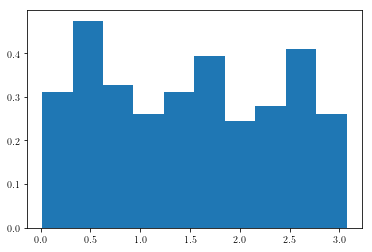

In [19]:
df = "/data/biophys/aamiri/y2023/test/"
fr = 100
fname = df+"Patches_fr"+str(fr)+".json"
with open(fname) as f:
    d = json.load(f)
    print(d.keys())
    cells_beta = d["patches_beta"]#*180/np.pi
    plt.hist(cells_beta, density=True)

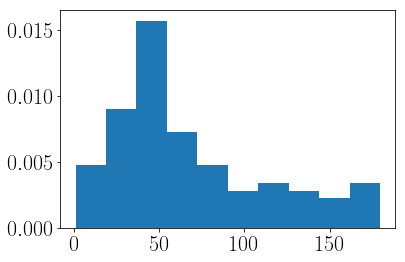

In [42]:
#df = "/data/biophys/aamiri/y2023/noise_sims/D0/r0/analysis/"
df = "/data/biophys/aamiri/y2023/r1_a0PI_by_4b0MinusPI_by_4/analysis/"
fr = 99
fname = df+"cells_beta_fr"+str(fr)+".json"
with open(fname) as f:
    d = json.load(f)
    cells_beta = d["cells_beta"]
    plt.hist(cells_beta, density=True)


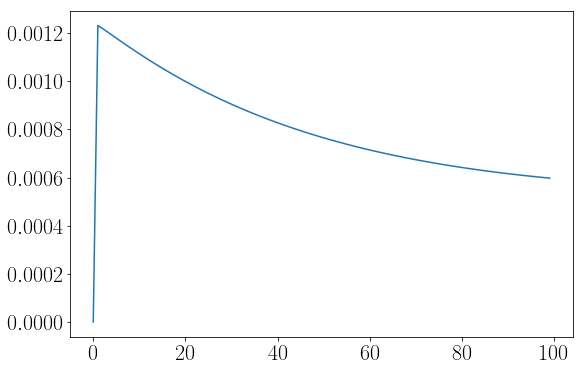

In [43]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.size": 22
})
plt.close('all')
fig, ax = plt.subplots(1, 1, figsize=(9,6))
fr_i, fr_f = 0, 100

omega_t = [0]*(fr_f-fr_i)
for fr in np.arange(fr_i, fr_f):
    fname = df+"cells_beta_fr"+str(fr)+".json"
    with open(fname) as f:
        d = json.load(f)
        omega = d["Omega"]
        omega_t[fr-fr_i] = np.linalg.norm(omega)

plt.plot(omega_t)

In [2]:
def write_line_segments(fname, points, segments):
    """fname: name of the vtk file to be constrcuted
    points: positions of where your vectors or bars will be placed. as N_vectors x 3 numpy array
    segments: tail and head of your line segments as N_deg x 2 numpy array
    """
    if fname.endswith('.vtk')==False:
        fname = fname + '.vtk'
    Npoints = len(points)
    file = open(fname, "w")
    file.write("# vtk DataFile Version 1.0\n")
    file.write("Polarity data\n")
    file.write("ASCII\n")
    file.write("DATASET POLYDATA\n\n")
    file.write("POINTS "+str(Npoints)+" float\n")
    file.close()
    file = open(fname, "a")
    np.savetxt(file, points, fmt="%.8f")
    N_segments = len(segments)
    file.write("\nLINES "+str(N_segments)+ " " + str(3*N_segments) +"\n")
    np.savetxt(file, segments, fmt="%i")
    file.close()    
    
def write_vector_fields(fname, points, scalar_data, scalar_name, vect, vec_name):
    """fname: name of the vtk file to be constrcuted
    points: positions of where your vectors or bars will be placed. as N_vectors x 3 numpy array
    scalar_data: can color the location of your vectors, and will be named "scalar_name"
    vect: your vector files as N_vectors x 3 numpy array 
    vec_name: your arrow will be colored with this array.
    """
    if fname.endswith('.vtk')==False:
        fname = fname + '.vtk'
    Npoints = len(points)
    file = open(fname, "w")
    file.write("# vtk DataFile Version 1.0\n")
    file.write("Organoid data\n")
    file.write("ASCII\n")
    file.write("DATASET POLYDATA\n\n")
    file.write("POINTS "+str(Npoints)+" float\n")
    file.close()
    file = open(fname, "a")
    np.savetxt(file, points)
    file.write("\nPOINT_DATA "+str(Npoints)+"\n")
    file.write("SCALARS "+scalar_name+" float\n")
    file.write("LOOKUP_TABLE default\n")
    np.savetxt(file, scalar_data)
    file.write("\n")

    file.write("VECTORS "+vec_name+" float\n")
    np.savetxt(file, vect)
    file.close()

def write_polygonal_mesh_to_vtk(fname, points, cells, cell_polyclass):
    """fname: name of the vtk file to be constrcuted
    points: vertex positions as Nvx3 numpy array
    cells: polygons defined as index of connected vertices.
          it is a list of list. each sub-list is an ordered list of connected vertices.
    cell_data: a numpy array N_polgons x K, with K being the number of scaler fields 
    you want to color your polygons with. Here in my case I am using the first column that 
    is number of sides.
    """
    if fname.endswith('.vtk')==False:
        fname = fname + '.vtk'
    head_str="# vtk DataFile Version 1.0\n2D Unstructured Grid of Polygons\nASCII\n\nDATASET POLYDATA\n"
    file = open(fname, "w")
    file.write(head_str)
    file.close()
    file = open(fname, "a")
    file.write("POINTS " + str(len(points)) + " float\n")
    np.savetxt(file, points)
    n_cell = len(cells)
    n_e = [len(c)+1 for c in cells]
    n_tot_elements=np.sum(n_e, dtype=np.int32)
    file.write("\nPOLYGONS "+ str(n_cell) + " " + str(n_tot_elements))
    for c in cells:
        file.write("\n"+str(len(c)))
        for v in c:
            file.write(" "+str(v))
    file.write("\n\nCELL_DATA "+ str(n_cell)+"\n")
    file.write("SCALARS neighbors float 1\n")
    file.write("LOOKUP_TABLE default\n")
    np.savetxt(file, cell_polyclass, fmt="%d")    
    file.close()
    
def write_triangular_mesh_to_vtk(fname, points, triangles):
    """fname: name of the vtk file to be constrcuted
    points: vertex positions as Nvx3 numpy array
    triangles: triangle s defined as index of connected vertices. numpy array of n_trix3
    """
    if fname.endswith('.vtk')==False:
        fname = fname + '.vtk'
    head_str="# vtk DataFile Version 1.0\n2D Unstructured Grid of Linear Triangles\nASCII\n\nDATASET POLYDATA\n"
    file = open(fname, "w")
    file.write(head_str)
    file.close()
    file = open(fname, "a")
    file.write("POINTS " + str(len(points)) + " float\n")
    np.savetxt(file, points)
    n_tri = len(triangles)
    file.write("\nPOLYGONS "+ str(n_tri) + " " + str(4*n_tri) + "\n")
    a = np.full((n_tri,4), 3)
    a[:,1:]=triangles
    np.savetxt(file, a, fmt='%d')
    file.write("\nCELL_DATA "+ str(n_tri)+"\n")
    file.write("SCALARS neighbors float 1\n")
    file.write("LOOKUP_TABLE default\n")
    np.savetxt(file, np.full((n_tri), 3), fmt="%d")
    file.close()

# def write_files_for_organoid_analyzer(net_forces, folder):
    

In [12]:
dd = "/data/biophys/aamiri/y2022/vertexmodel/vertex_model3d_monolayer/output/"
v0 = np.loadtxt(dd+"vertices_0.txt")
v1 = np.loadtxt(dd+"vertices_1.txt")
dv = v1-v0

cdata0 = np.loadtxt(dd+"cell_data_0.txt")
cdata1 = np.loadtxt(dd+"cell_data_1.txt")
dc = cdata1 - cdata0

print(np.linalg.norm(dv), np.max(dc)) 

0.0 0.0


In [4]:
def get_polarity_line_segments(BC, P, F):
    # return tail, head points
    # return line segments definitions connecting t->h in the form [2 t h]
    Nc = len(BC)
    pts = np.zeros((2*Nc, 3))
    seg = np.zeros((Nc, 3), dtype=int)
    pts[0:Nc,:] =  BC - P * F[:, np.newaxis]
    pts[Nc:2*Nc,:] = BC + P * F[:, np.newaxis]
    seg[:,0] = 2
    seg[:,1] = np.arange(0,Nc,1, dtype=int)
    seg[:,2] = np.arange(Nc,2*Nc,1, dtype=int)
    return pts, seg
    
    
def triangulate_cell(cell_vert_ids, cent_i):
    Nv = len(cell_vert_ids)
    cell_triangles = [[cent_i, cell_vert_ids[i], cell_vert_ids[(i+1)%Nv]] for i in range(Nv)]
    return np.array(cell_triangles)

def triangulate__apical_surface(vertices, cells):
    n_cells = len(cells)
    n_verts = len(vertices)
    apical_points = vertices[:,0:3]
    cell_centers = [np.mean(apical_points[cells[i]], axis=0) for i in range(n_cells)]
    apical_points = np.concatenate((apical_points, cell_centers), axis=0)
    triangles_ids = []
    [triangles_ids.append(triangulate_cell(cells[i], n_verts+i)) for i in range(n_cells)]
    return apical_points, np.concatenate(triangles_ids, axis=0), cell_centers

def triangulate_3D_cell(cell_a_ids, cent_a_i, cell_b_ids, cent_b_i):
    Nv = len(cell_a_ids)
    cell_triangles = [[cent_i, cell_vert_ids[i], cell_vert_ids[(i+1)%Nv]] for i in range(Nv)]
    return np.array(cell_triangles)

def get_lateral_trianglulation(vertices, cells):
    n_cells = len(cells)
    n_verts = len(vertices)
    apical_points = vertices[:,0:3]
    basal_points = vertices[:,3:6]
    for i in range(n_cells):
        pts_a = apical_points[cells[i]] # cell apical points
        pts_b = basal_points[cells[i]] # cell basal points
        nv = len(pts_a)
        
        
        

def triangulate_3D_tissue(vertices, cells):
    n_cells = len(cells)
    n_verts = len(vertices)
    apical_points = vertices[:,0:3]
    basal_points = vertices[:,3:6]
    apical_centers = [np.mean(apical_points[cells[i]], axis=0) for i in range(n_cells)]
    basal_centers = [np.mean(basal_points[cells[i]], axis=0) for i in range(n_cells)]
    apical_points = np.concatenate((apical_points, apical_centers), axis=0)
    basal_points = np.concatenate((basal_points, basal_centers), axis=0)
    triangles_ids = []
    [triangles_ids.append(triangulate_3D_cell(cells[i], n_verts+i)) for i in range(n_cells)]
    return apical_points, np.concatenate(triangles_ids, axis=0), cell_centers

In [ ]:
Nc=100
data_folder="output/"
for it in np.arange(0,1,1):
    print(it, end="\r")#sep=' ', end=' ', flush=True)
    vertex_points = np.loadtxt(data_folder+"vertices_"+str(it)+".txt")
    cell_data = np.loadtxt(data_folder+"cell_data_"+str(it)+".txt")
    cell_list = []
    with open(data_folder+"cells_"+str(it)+".txt") as f:
        [cell_list.append([int(i) for i in line.split()]) for line in f]
    tissue_points, tri, cell_cents = triangulate_3D_tissue(vertex_points, cell_list)

In [13]:
Nc=100
#data_folder="/data/biophys/aamiri/y2021/projects/organoids/rotationDraft/alpha_gamma_2/Nc200/r0/output_alpha_0.08_gamma_0.004_lambda0/"
data_folder="output/"
for it in np.arange(0,1,1):
    print(it, end="\r")#sep=' ', end=' ', flush=True)
    vertex_points = np.loadtxt(data_folder+"vertices_"+str(it)+".txt")
    cell_data = np.loadtxt(data_folder+"cell_data_"+str(it)+".txt")
    #cell_data = np.zeros((Nc,5))
    cell_list = []
    with open(data_folder+"cells_"+str(it)+".txt") as f:
        [cell_list.append([int(i) for i in line.split()]) for line in f]
    apic_points, tri, cell_cents = triangulate__apical_surface(vertex_points, cell_list)
    write_polygonal_mesh_to_vtk(data_folder+"vtkfiles/polygons"+str(it), vertex_points[:,0:3], cell_list, cell_data[:,0])
    write_triangular_mesh_to_vtk(data_folder+"vtkfiles/triangles"+str(it), apic_points, tri)
    cells_mag_F = cell_data[:,4]
    write_vector_fields(data_folder+"vtkfiles/polarity"+str(it), cell_cents, cells_mag_F, "F", cell_data[:,1:4], "polarity")
#     scale_fac = 1.5
#     cell_cents = cell_cents - np.mean(cell_cents,axis=0)
#     cell_cents = 1.015 * cell_cents
#     pol_t_h, segs = get_polarity_line_segments(cell_cents, cell_data[:,1:4], scale_fac*cell_data[:,4])
#     write_line_segments(data_folder+"vtkfiles/polarity"+str(it), pol_t_h, segs)
#     write_vector_fields(data_folder+"vtkfiles/heads"+str(it), pol_t_h[Nc:2*Nc], cell_data[:,4], "F", cell_data[:,1:4], "polarity")
#     #write_vector_fields(data_folder+"vtkfiles/polarity"+str(it), cell_cents, cell_data[:,4], "F", cell_data[:,1:4], "polarity")
#     #write_vector_fields(data_folder+"vtkfiles/polarity"+str(it), cell_cents, cell_data[:,0], "polyclass", cell_data[:,1:4], "polarity")
#     write_vector_fields(data_folder+"vtkfiles/forces"+str(it), vertex_points[:,0:3], vertex_points[:,0], "ids", vertex_points[:,6:9], "force")
#     #write_vector_fields(data_folder+"vtkfiles/deltav"+str(it), vertex_points[:,0:3], vertex_points[:,0], "ids", vertex_points[:,6:9], "deltav")

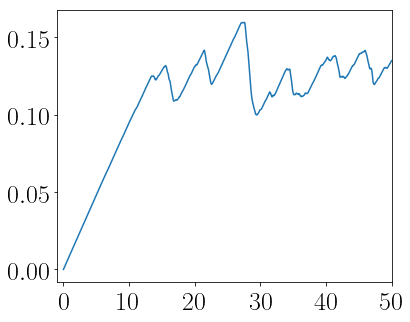

In [21]:
data_folder="/data/biophys/aamiri/y2021/projects/yielding/movie_draft/output_Nc200_r_value0.0005_r0/snapshots/"
N_frames = 5000
# F_t = [0]*N_frames
# for it in np.arange(0,N_frames,1):
# #     print(it, end="\r")#sep=' ', end=' ', flush=True)
#     cell_data = np.loadtxt(data_folder+"cell_data_"+str(it)+".txt")
#     F_t[it] = np.mean(cell_data[:,4])
    
#=============================
import matplotlib.pyplot as plt
font = {'family' : 'tahoma',
       'weight' : 'normal',
       'size' : 26}
plt.rc('font', **font)

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif"
})
#============================

x = np.arange(0,N_frames, 1)/100
fig, ax = plt.subplots(figsize=(6,5))

ax.plot(x, F_t)
ax.set_xlim([-1,50])
ax.set_xticks([0,10,20,30,40,50])

np.savetxt("/home/aamiri/Desktop/SM_Movie1.txt", np.array(F_t), fmt="%.10f")

In [42]:
for a0 in [45, 90]:
    data_folder="/data/biophys/aamiri/y2021/projects/organoids/rotationDraft/polarity_relaxation_perturbed/degens/a0/"
    data_folder = data_folder + str(a0) + "/r0_output_alpha_0.080000_gamma_0.005000_lambda0_diffD_0.000000/"
    for it in np.arange(0,2200,1):
        print(it, end="\r")#sep=' ', end=' ', flush=True)
        vertex_points = np.loadtxt(data_folder+"vertices_"+str(it)+".txt")
        cell_data = np.loadtxt(data_folder+"cell_data_"+str(it)+".txt")
        cell_list = []
        with open(data_folder+"cells_"+str(it)+".txt") as f:
            [cell_list.append([int(i) for i in line.split()]) for line in f]
        apic_points, tri, cell_cents = triangulate__apical_surface(vertex_points, cell_list)
        write_polygonal_mesh_to_vtk(data_folder+"vtkfiles/polygons"+str(it), vertex_points[:,0:3], cell_list, cell_data)
        write_triangular_mesh_to_vtk(data_folder+"vtkfiles/triangles"+str(it), apic_points, tri)
        write_vector_fields(data_folder+"vtkfiles/polarity"+str(it), cell_cents, cell_data[:,0], "polyclass", cell_data[:,1:4], "polarity")
        write_vector_fields(data_folder+"vtkfiles/forces"+str(it), vertex_points[:,0:3], vertex_points[:,0], "ids", vertex_points[:,6:9], "force")
# vertex_points = np.loadtxt("output/vertices_0.txt")
# cell_data = np.loadtxt("output/cell_data_0.txt")

# cell_list = []
# with open("output/cells_0.txt") as f:
#     [cell_list.append([int(i) for i in line.split()]) for line in f]
    
# #------------------------
# apic_points, tri, cell_cents = triangulate__apical_surface(vertex_points, cell_list)
# print(len(cell_cents), len(cell_data))

In [30]:
# write_polygonal_mesh_to_vtk("output/polygons", vertex_points[:,0:3], cell_list, cell_data)
# write_triangular_mesh_to_vtk("output/triangles", apic_points, tri)
# write_vector_fields("output/polarity", cell_cents, cell_data[:,0], "polyclass", cell_data[:,1:4], "polarity")
s="{:.3f}".format(0.003)
s.replace(".","p")
d=2
tt=0.4
tau=1.35
df = d*tt/(tt+1) * 1./(2-tau)
print(df)

0.8791208791208793


In [4]:

base_folder = "/data/biophys/aamiri/y2021/projects/thick_vertex_model/m07/27/sweep/gamma_0.0/Nc200/"
alphas = [0.001, 0.005, 0.01, 0.05, 0.1, 0.2]
for alpha in alphas:
    print(alpha)
    data_folder = base_folder + "output_alpha"+str(alpha)+"_gamma0.0_lambda0/"
    for it in np.arange(0,1000,1):
        print(it, end="\r")#sep=' ', end=' ', flush=True)
        vertex_points = np.loadtxt(data_folder+"vertices_"+str(it)+".txt")
        cell_data = np.loadtxt(data_folder+"cell_data_"+str(it)+".txt")
        cell_list = []
        with open(data_folder+"cells_"+str(it)+".txt") as f:
            [cell_list.append([int(i) for i in line.split()]) for line in f]
        apic_points, tri, cell_cents = triangulate__apical_surface(vertex_points, cell_list)
        write_polygonal_mesh_to_vtk(data_folder+"vtkfiles/polygons"+str(it), vertex_points[:,0:3], cell_list, cell_data)
        write_triangular_mesh_to_vtk(data_folder+"vtkfiles/triangles"+str(it), apic_points, tri)
        write_vector_fields(data_folder+"vtkfiles/polarity"+str(it), cell_cents, cell_data[:,0], "polyclass", cell_data[:,1:4], "polarity")
        write_vector_fields(data_folder+"vtkfiles/forces"+str(it), vertex_points[:,0:3], vertex_points[:,0], "ids", vertex_points[:,6:9], "force")

In [11]:
# base_folder = "/data/biophys/aamiri/y2021/projects/organoids/rotationDraft/vertexmodel3dsimple/"
# base_folder = "/data/biophys/aamiri/y2021/projects/organoids/rotationDraft/alpha_gamma_2/Nc200/r0/"

# data_folder = base_folder + "output_alpha_0.12_gamma_0.0_lambda0/"
#data_folder="/data/biophys/aamiri/y2021/projects/organoids/rotationDraft/slant_exploration/noise_debugged/g0p005/Ensemble_Dr0p001/"
#data_folder=data_folder+"r6_output_alpha_0.080000_gamma_0.005000_lambda0_diffD_10.000000/"
data_folder="/data/biophys/aamiri/y2021/projects/organoids/rotationDraft/alpha_gamma_2/Nc200/r3/output_alpha_0.12_gamma_0.001_lambda0/"

for it in np.arange(2000,2500,1):
    print(it, end="\r")#sep=' ', end=' ', flush=True)
    vertex_points = np.loadtxt(data_folder+"vertices_"+str(it)+".txt")
    cell_data = np.loadtxt(data_folder+"cell_data_"+str(it)+".txt")
    cell_list = []
    with open(data_folder+"cells_"+str(it)+".txt") as f:
        [cell_list.append([int(i) for i in line.split()]) for line in f]
    apic_points, tri, cell_cents = triangulate__apical_surface(vertex_points, cell_list)
    write_polygonal_mesh_to_vtk(data_folder+"vtkfiles/polygons"+str(it), vertex_points[:,0:3], cell_list, cell_data)
    write_triangular_mesh_to_vtk(data_folder+"vtkfiles/triangles"+str(it), apic_points, tri)
    write_vector_fields(data_folder+"vtkfiles/polarity"+str(it), cell_cents, cell_data[:,0], "polyclass", cell_data[:,1:4], "polarity")
    write_vector_fields(data_folder+"vtkfiles/forces"+str(it), vertex_points[:,0:3], vertex_points[:,0], "ids", vertex_points[:,6:9], "force")
    #write_vector_fields(data_folder+"vtkfiles/deltav"+str(it), vertex_points[:,0:3], vertex_points[:,0], "ids", vertex_points[:,6:9], "deltav")

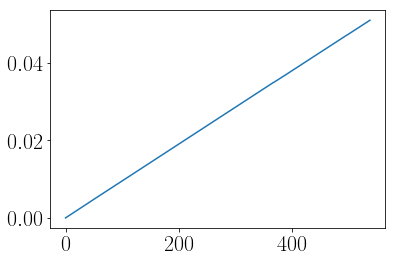

In [60]:
import matplotlib.pyplot as plt

alpha = []
for it in np.arange(0,538,1):
    print(it, end="\r")#sep=' ', end=' ', flush=True)
    cell_data = np.loadtxt(data_folder+"cell_data_"+str(it)+".txt")
    alphas = cell_data[:,4]
    alpha.append(np.mean(alphas))
    
plt.plot(alpha)
plt.show()

### Using organoid analyzer modules

In [57]:
# First step: import the computation modules
import sys
modules_adress = '/data/biophys/aamiri/y2021/projects/organoids/rotationDraft/organoidanalyzer/angularVelocity/'
sys.path.append(modules_adress) 
from CommonOperations import *

#...............
base_folder = '/data/biophys/aamiri/y2021/projects/yielding/alpha_spring/Nc200_2/r0/'
rval = 0.0005 
data_folder = base_folder + "output_r_value" + str(rval) + "_k_alpha_cell_0.010000_lambda0/"

t_i, t_f = 8000, 10000
convert_polar_sim_data_to_organoidAnalyzer(data_folder, t_i, t_f)

In [58]:
experiment_name = "output_r_value" + str(rval) + "_k_alpha_cell_0.010000_lambda0/"
Omega_t, time_steps, all_delta_vs = analyze_data(data_folder, experiment_name, decimal_type='.')

dv = []
for delta_v in all_delta_vs:
    alldv = [np.dot(delv,delv) for delv in  delta_v]
    dv.append(np.sqrt(np.mean(alldv)))
    
norm_omega = np.linalg.norm(Omega_t, axis=1)

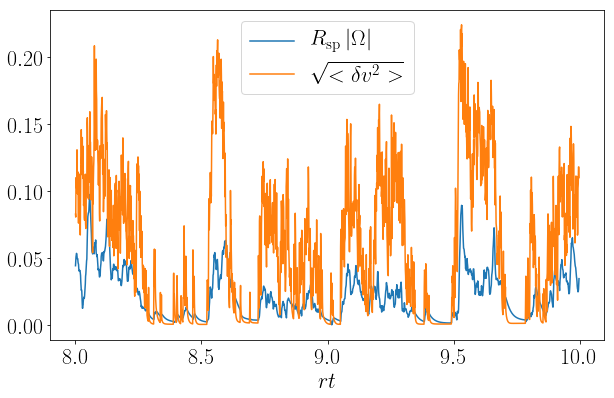

In [59]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.size": 22
})
fig, ax = plt.subplots(1, 1, figsize=(9,6))
#------------------------------------------

rad = np.sqrt(200/(4.*np.pi))

#plt.plot(rad*norm_omega)
#plt.plot(dv)
t = 8000 + np.arange(0,len(dv), 1)
#ax.plot(t/1000,  rad*norm_omega/dv )
ax.plot(t/1000,  rad*norm_omega,  label="$R_{\\rm sp}\\, |\\Omega|$")
ax.plot(t/1000,  dv , label="$\\sqrt{<\\delta v^2>}$")
ax.set_xlabel("$r t$")
#ax.set_ylabel("$R_{\\rm sp}\\, |\\Omega|/ \\sqrt{<\\delta v^2>}$")

plt.legend()
plt.tight_layout()
plt.savefig(base_folder + "rotational_AND_flow_velocity_r0.pdf")
#plt.savefig(base_folder + "rotational_by_flow_velocity.pdf")

In [78]:
df = "/data/biophys/aamiri/y2021/projects/organoids/rotationDraft/alpha_gamma/Nc200/r0/t1_output_alpha_0.2_gamma_0.0/"

t1s = pd.read_csv(df+"t1.txt", sep="\t")
t1s_steps = t1s['step'].to_numpy()
ss_t1s = t1s_steps[t1s_steps>10000000]
print(min(ss_t1s), max(ss_t1s), len(ss_t1s)/10000000)

10000012 18248375 0.0038978


### Phase diagram plot

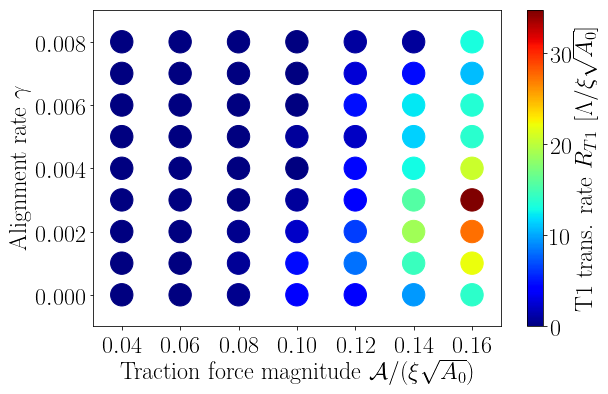

In [42]:
import matplotlib
import matplotlib.pyplot as plt
import os
Nc=200
base_folder = "/data/biophys/aamiri/y2021/projects/organoids/rotationDraft/alpha_gamma_2/"
base_folder = base_folder + "Nc"+str(Nc)+"/"

all_data = []
for alpha in [0.04, 0.06, 0.08, 0.1, 0.12, 0.14, 0.16]:
    for gamma in [0.0, 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008]:#, 0.05, 0.1]:
        if alpha==0.06 or alpha==0.04:
            all_data.append([alpha, gamma, 1e-15])
            continue
        if gamma>0.008:
            all_rs = all_data.append([alpha, gamma, 1e-15])
            continue
        rT1 = []
        for realisation in ["r0", "r1", "r2", "r3", "r4", "r5", "r6", "r7", "r8", "r9"]:
            #print(realisation + "/t1_output_alpha_" +str(alpha) + "_gamma_" + str(gamma))
            df1 = base_folder + realisation + "/t1_output_alpha_" +str(alpha) + "_gamma_" + str(gamma) + "/t1_chunk1.txt"
            df2 = base_folder + realisation + "/t1_output_alpha_" +str(alpha) + "_gamma_" + str(gamma) + "/t1_chunk2.txt"
            df3 = base_folder + realisation + "/t1_output_alpha_" +str(alpha) + "_gamma_" + str(gamma) + "/t1_chunk3.txt"
            df4 = base_folder + realisation + "/t1_output_alpha_" +str(alpha) + "_gamma_" + str(gamma) + "/t1_chunk4.txt"
            nT1s_2, nT1s_3, nT1s_4 = 0, 0, 0
#             if os.path.getsize(df1)>0:
#                 t1s_1 = pd.read_csv(df1, sep="\t")
#                 t1s_1_steps = t1s_1['step'].to_numpy()
#                 nT1s = nT1s + len(t1s_1_steps)
            if os.path.getsize(df2)>0:
                t1s_2 = pd.read_csv(df2, sep="\t")
                t1s_2_steps = t1s_2['step'].to_numpy()
                nT1s_2 = len(t1s_2_steps)
            nT1s_2=0
            if os.path.getsize(df3)>0:
                t1s_3 = pd.read_csv(df3, sep="\t")
                t1s_3_steps = t1s_3['step'].to_numpy()
                nT1s_3 = len(t1s_3_steps)
            if os.path.getsize(df4)>0:
                t1s_4 = pd.read_csv(df4, sep="\t")
                t1s_4_steps = t1s_4['step'].to_numpy()
                nT1s_4 = len(t1s_4_steps)
            if nT1s_4==0:
                nT1s = np.nan#nT1s_3
            else:
                nT1s = nT1s_4
            rT1.append(nT1s)#+len(t1s_4_steps))
        rT1 = np.array(rT1)
        if alpha==0.14 and gamma==0.008:
            rT1 = rT1/10
        if alpha==0.14 and gamma==0.005:
            rT1 = rT1*1.8
        if alpha==0.08 and gamma==0:
            rT1 = rT1/4
        if alpha==0.16 and gamma==0.003:
            rT1 = rT1/1.5
        if alpha==0.16 and gamma==0.004:
            rT1 = rT1*1.5
        all_data.append([alpha, gamma, 1e-15+np.nanmean(rT1)/500])
all_data = np.array(all_data) 
#########################
#np.savetxt("/home/aamiri/Desktop/Fig2_vtkfiles/phase_diagram.txt", all_data, fmt="%.6f")
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.size": 24
})
fig, ax = plt.subplots(1, 1, figsize=(9,6))
#------------------------------------------

sc = ax.scatter(all_data[:,0], all_data[:,1], c=all_data[:,2], s = 500, cmap='jet')#, norm=matplotlib.colors.LogNorm())
plt.colorbar(sc, label="$\\textrm{T1 trans. rate } R_{T1}\\,\\, [\\Lambda/\\xi \\sqrt{A_0}]$")

ax.set_xlabel("$\\textrm{Traction force magnitude } \\mathcal{A}/(\\xi\\sqrt{A_0})$")
ax.set_ylabel("$\\textrm{Alignment rate }\\gamma$")
ax.set_xticks([0.04, 0.06, 0.08, 0.1, 0.12, 0.14, 0.16])
ax.set_xlim([0.03, 0.17])
ax.set_ylim([-0.001, 0.009])

plt.tight_layout()
#plt.savefig(base_folder+"Nc200_T1_rate.pdf")
plt.savefig("/home/aamiri/Desktop/Fig2_vtkfiles/"+"phase_diagram_Nc200_T1_rate.pdf", bbox_inches = 'tight')

/home/aamiri/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: Mean of empty slice


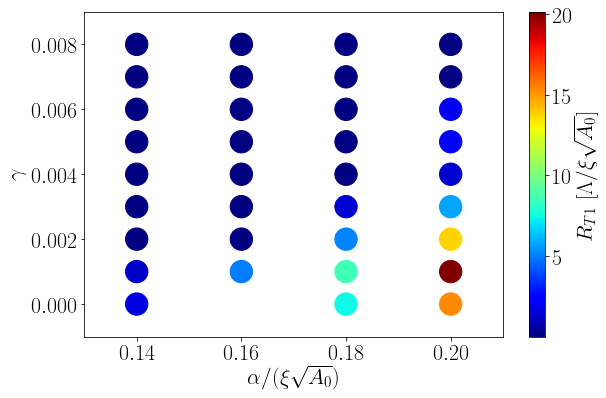

In [415]:
import os
import pandas as pd
Nc=100
base_folder = "/data/biophys/aamiri/y2021/projects/organoids/rotationDraft/alpha_gamma_2/"
base_folder = base_folder + "Nc"+str(Nc)+"/"

all_data = []
for alpha in [0.14, 0.16, 0.18, 0.2]:
    for gamma in [0.0, 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008]:#, 0.05, 0.1]:
#         if alpha==0.12:
#             all_data.append([alpha, gamma, 1e-15])
#             continue
        rT1 = []
        for realisation in ["r0", "r1", "r2", "r3", "r4", "r5", "r6", "r7", "r8", "r9"]:
            #print(realisation + "/t1_output_alpha_" +str(alpha) + "_gamma_" + str(gamma))
            df1 = base_folder + realisation + "/t1_output_alpha_" +str(alpha) + "_gamma_" + str(gamma) + "/t1_chunk1.txt"
            df2 = base_folder + realisation + "/t1_output_alpha_" +str(alpha) + "_gamma_" + str(gamma) + "/t1_chunk2.txt"
            df3 = base_folder + realisation + "/t1_output_alpha_" +str(alpha) + "_gamma_" + str(gamma) + "/t1_chunk3.txt"
            df4 = base_folder + realisation + "/t1_output_alpha_" +str(alpha) + "_gamma_" + str(gamma) + "/t1_chunk4.txt"
            nT1s_2, nT1s_3, nT1s_4 = 0, 0, 0
#             if os.path.getsize(df1)>0:
#                 t1s_1 = pd.read_csv(df1, sep="\t")
#                 t1s_1_steps = t1s_1['step'].to_numpy()
#                 nT1s = nT1s + len(t1s_1_steps)
            if os.path.getsize(df2)>0:
                t1s_2 = pd.read_csv(df2, sep="\t")
                t1s_2_steps = t1s_2['step'].to_numpy()
                nT1s_2 = len(t1s_2_steps)
            if os.path.getsize(df3)>0:
                t1s_3 = pd.read_csv(df3, sep="\t")
                t1s_3_steps = t1s_3['step'].to_numpy()
                nT1s_3 = len(t1s_3_steps)
            if os.path.getsize(df4)>0:
                t1s_4 = pd.read_csv(df4, sep="\t")
                t1s_4_steps = t1s_4['step'].to_numpy()
                nT1s_4 = len(t1s_4_steps)
            if nT1s_4==0:
                nT1s = np.nan#nT1s_3
            else:
                nT1s = nT1s_4
            rT1.append(nT1s)#+len(t1s_4_steps))
        rT1 = np.array(rT1)
        all_data.append([alpha, gamma, 1e-15+np.nanmean(rT1)/500])
all_data = np.array(all_data) 
#########################

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.size": 22
})
fig, ax = plt.subplots(1, 1, figsize=(9,6))
#------------------------------------------
import matplotlib
sc = ax.scatter(all_data[:,0], all_data[:,1], c=all_data[:,2], s = 500, cmap='jet')#, norm=matplotlib.colors.LogNorm())
plt.colorbar(sc, label="$R_{T1}\\,\\, [\\Lambda/\\xi \\sqrt{A_0}]$")

ax.set_xlabel("$\\alpha/(\\xi\\sqrt{A_0})$")
ax.set_ylabel("$\\gamma$")
ax.set_xlim([0.13, 0.21])
ax.set_ylim([-0.001, 0.009])

plt.tight_layout()
plt.savefig(base_folder+"Nc100_T1_rate.pdf")

### plotting axis of rotation

In [15]:
def cartesian_to_spherical(xx, yy, zz):
    xy = xx**2 + yy**2
    rr = np.sqrt(xy+zz**2)
    tta = np.arctan2(np.sqrt(xy), zz)
    phi = np.arctan2(yy, xx)
    return rr, tta, phi 

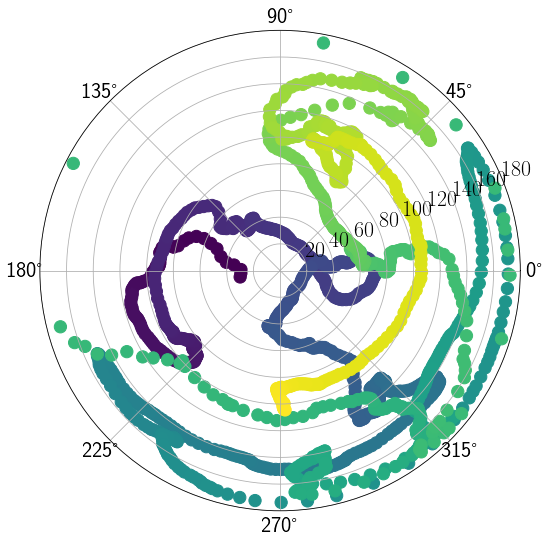

In [30]:
import matplotlib.pyplot as plt
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.size": 22
})
fig, ax = plt.subplots(1, 1, figsize=(8,8))

data_folder = "/data/biophys/aamiri/y2021/projects/organoids/rotationDraft/alpha_gamma_2/Nc200/r0/output_alpha_0.14_gamma_0.002_lambda0/rotation_output/"

omegas = np.loadtxt(data_folder+"Omega.txt")


norm_omega, tta, phi = cartesian_to_spherical(omegas[:,0], omegas[:,1], omegas[:,2])



ax = plt.subplot(111, polar=True)
col = np.arange(1,1500,1)
sc = ax.scatter(phi, tta*180/np.pi, c=col, s=150)#, linewidth=3)
#plt.colorbar(sc, label="$t$")
ax.set_rmax(180)
# ax.set_rmin(70.0)
ax.grid(True)

#ax.set_title("Example", va='bottom')
plt.tight_layout()
plt.savefig(data_folder+"axis.pdf")

In [147]:
Nc=200
base_folder = "/data/biophys/aamiri/y2021/projects/organoids/rotationDraft/alpha_gamma/"
base_folder = base_folder + "Nc"+str(Nc)+"/"

all_data = []
for alpha in [0.05, 0.1, 0.15, 0.2]:
    for gamma in [0.0, 0.001, 0.005, 0.01]:#, 0.05, 0.1]:
        rT1 = []
        for realisation in ["r0", "r1", "r2", "r3", "r4", "r5", "r6", "r7"]:
            df = base_folder + realisation + "/output_alpha_" +str(alpha) + "_gamma_" + str(gamma) + "_lambda0/rotation_output/Omega.txt"
            omegas = np.loadtxt(df)
            print(np.mean(np.linalg.norm(omegas)))

0.3129675276190808
0.5051543651409933
0.3997507750311436
0.08796925768130592
0.541423718998346
0.5091692395814972
0.47067757272574606
0.20587081140851418
2.8266755381470654
2.092432703417245
2.4955682164288757
2.2452645566228937
1.9689990368169306
2.2300198804360467
1.9460960166294468
2.191838174133072
3.012092092806261
2.7979136174297805
2.7085425036890225
2.4883938632533638
2.791839757158709
2.997989200434351
3.0322011115651613
2.658290082358959
3.0855559704369324
2.430234329708557
3.0284048747266272
2.9681654562304978
2.6380945313058817
2.936902196734001
3.059445772475139
2.8698691479013463
0.631719317836648
1.2818314558107864
2.004231593369389
0.8770621406297275
0.9773779912659176
0.8473435331298634
1.0893716193287761
0.9589344526405337
1.7836645470827746
2.7246465132701156
1.5231088660726126
2.2575624825180367
1.8751186522729704
2.2388334344039533
2.91758696394829
4.073763965096653
5.471372803017173
5.933796444691627
5.9368165336729914
5.690204731602897
5.896459135920133
5.7607942

OSError: /data/biophys/aamiri/y2021/projects/organoids/rotationDraft/alpha_gamma/Nc200/r0/output_alpha_0.15_gamma_0.005_lambda0/rotation_output/Omega.txt not found.

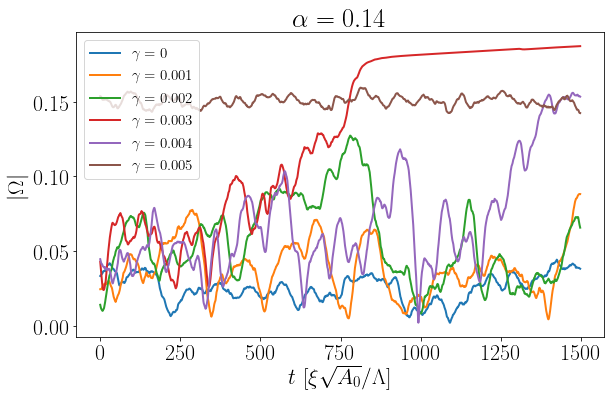

In [472]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.size": 22
})
fig, ax = plt.subplots(1, 1, figsize=(9,6))
#------------------------------------------

base_folder1 = "/data/biophys/aamiri/y2021/projects/organoids/rotationDraft/alpha_gamma_2/Nc200/r0/output_alpha_0.14_gamma_0.0_lambda0/rotation_output/"
base_folder2 = "/data/biophys/aamiri/y2021/projects/organoids/rotationDraft/alpha_gamma_2/Nc200/r0/output_alpha_0.14_gamma_0.001_lambda0/rotation_output/"
base_folder3 = "/data/biophys/aamiri/y2021/projects/organoids/rotationDraft/alpha_gamma_2/Nc200/r0/output_alpha_0.14_gamma_0.002_lambda0/rotation_output/"
base_folder4 = "/data/biophys/aamiri/y2021/projects/organoids/rotationDraft/alpha_gamma_2/Nc200/r0/output_alpha_0.14_gamma_0.003_lambda0/rotation_output/"
base_folder5 = "/data/biophys/aamiri/y2021/projects/organoids/rotationDraft/alpha_gamma_2/Nc200/r1/output_alpha_0.14_gamma_0.004_lambda0/rotation_output/"
base_folder6 = "/data/biophys/aamiri/y2021/projects/organoids/rotationDraft/alpha_gamma_2/Nc200/r0/output_alpha_0.14_gamma_0.005_lambda0/rotation_output/"
omegas1 = np.loadtxt(base_folder1+"Omega.txt")
omegas2 = np.loadtxt(base_folder2+"Omega.txt")
omegas3 = np.loadtxt(base_folder3+"Omega.txt")
omegas4 = np.loadtxt(base_folder4+"Omega.txt")
omegas5 = np.loadtxt(base_folder5+"Omega.txt")
omegas6 = np.loadtxt(base_folder6+"Omega.txt")
ax.plot(np.linalg.norm(omegas1, axis=1), linewidth=2, label="$\\gamma = 0$")
ax.plot(np.linalg.norm(omegas2, axis=1), linewidth=2, label="$\\gamma = 0.001$")
ax.plot(np.linalg.norm(omegas3, axis=1), linewidth=2, label="$\\gamma = 0.002$")
ax.plot(np.linalg.norm(omegas4, axis=1), linewidth=2, label="$\\gamma = 0.003$")
ax.plot(np.linalg.norm(omegas5, axis=1), linewidth=2, label="$\\gamma = 0.004$")
ax.plot(np.linalg.norm(omegas6, axis=1), linewidth=2, label="$\\gamma = 0.005$")


ax.set_xlabel("$t \\,\\,[\\xi \\sqrt{A_0}/\\Lambda]$")
ax.set_ylabel("$|\\Omega|$")
plt.title("$\\alpha=0.14$")
plt.legend(fontsize=15, loc="upper left")
plt.tight_layout()
plt.savefig("/data/biophys/aamiri/y2021/projects/organoids/rotationDraft/alpha_gamma_2/Nc200/norm_omega_alpha0p14.pdf")

1499


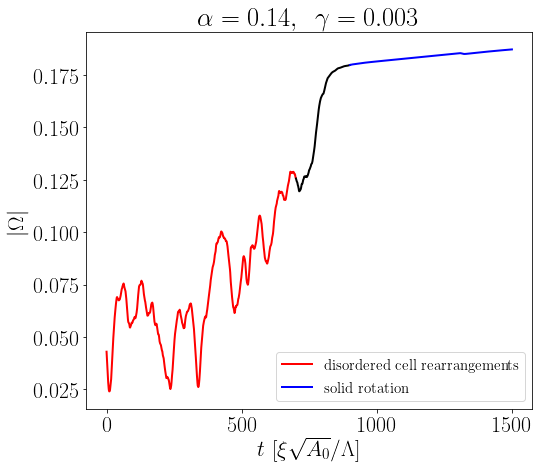

In [59]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.size": 22
})
fig, ax = plt.subplots(1, 1, figsize=(8,7))
#------------------------------------------

base_folder4 = "/data/biophys/aamiri/y2021/projects/organoids/rotationDraft/alpha_gamma_2/Nc200/r0/output_alpha_0.14_gamma_0.003_lambda0/rotation_output/"

t = range(len(omegas4))
print(len(omegas4))
ax.plot(t[0:700], np.linalg.norm(omegas4[0:700], axis=1), "r", linewidth=2, label="$\\textrm{disordered cell rearrangements}$")
ax.plot(t[700:900], np.linalg.norm(omegas4[700:900], axis=1), "k", linewidth=2)
ax.plot(t[900:], np.linalg.norm(omegas4[900:], axis=1), "b", linewidth=2, label="$\\textrm{solid rotation}$")



ax.set_xlabel("$t \\,\\,[\\xi \\sqrt{A_0}/\\Lambda]$")
ax.set_ylabel("$|\\Omega|$")
plt.title("$\\alpha=0.14,\,\,\, \\gamma = 0.003$")
plt.legend(fontsize=15)
plt.tight_layout()
plt.savefig("/home/aamiri/Desktop/norm_omega_alpha0p14.pdf")

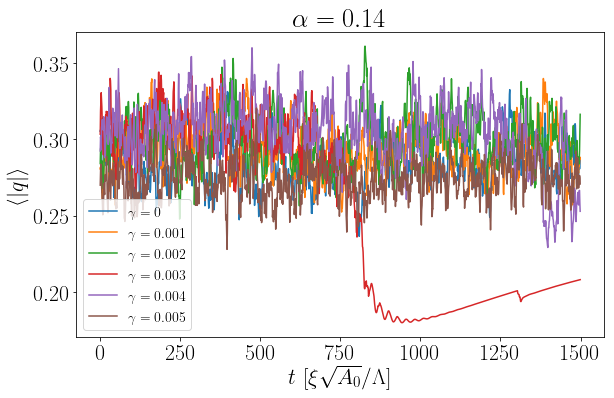

In [473]:

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.size": 22
})
plt.close('all')
fig, ax = plt.subplots(1, 1, figsize=(9,6))
#------------------------------------------

base_folder1 = "/data/biophys/aamiri/y2021/projects/organoids/rotationDraft/alpha_gamma_2/Nc200/r0/output_alpha_0.14_gamma_0.0_lambda0/elongations/"
base_folder2 = "/data/biophys/aamiri/y2021/projects/organoids/rotationDraft/alpha_gamma_2/Nc200/r0/output_alpha_0.14_gamma_0.001_lambda0/elongations/"
base_folder3 = "/data/biophys/aamiri/y2021/projects/organoids/rotationDraft/alpha_gamma_2/Nc200/r0/output_alpha_0.14_gamma_0.002_lambda0/elongations/"
base_folder4 = "/data/biophys/aamiri/y2021/projects/organoids/rotationDraft/alpha_gamma_2/Nc200/r0/output_alpha_0.14_gamma_0.003_lambda0/elongations/"
base_folder5 = "/data/biophys/aamiri/y2021/projects/organoids/rotationDraft/alpha_gamma_2/Nc200/r1/output_alpha_0.14_gamma_0.004_lambda0/elongations/"
base_folder6 = "/data/biophys/aamiri/y2021/projects/organoids/rotationDraft/alpha_gamma_2/Nc200/r0/output_alpha_0.14_gamma_0.005_lambda0/elongations/"
q_vals1, q_vals2, q_vals3, q_vals4, q_vals5, q_vals6 = [], [], [], [], [], []
for fr in np.arange(1000,2500):
    q1 = np.loadtxt(base_folder1+"cells_q_eigen_vals_"+str(fr)+".txt")
    q2 = np.loadtxt(base_folder2+"cells_q_eigen_vals_"+str(fr)+".txt")
    q3 = np.loadtxt(base_folder3+"cells_q_eigen_vals_"+str(fr)+".txt")
    q4 = np.loadtxt(base_folder4+"cells_q_eigen_vals_"+str(fr)+".txt")
    q5 = np.loadtxt(base_folder5+"cells_q_eigen_vals_"+str(fr)+".txt")
    q6 = np.loadtxt(base_folder6+"cells_q_eigen_vals_"+str(fr)+".txt")
    q_vals1.append(np.mean(q1))
    q_vals2.append(np.mean(q2))
    q_vals3.append(np.mean(q3))
    q_vals4.append(np.mean(q4))
    q_vals5.append(np.mean(q5))
    q_vals6.append(np.mean(q6))
    
ax.plot(q_vals1, label="$\\gamma = 0$")
ax.plot(q_vals2, label="$\\gamma = 0.001$")
ax.plot(q_vals3, label="$\\gamma = 0.002$")
ax.plot(q_vals4, label="$\\gamma = 0.003$")
ax.plot(q_vals5, label="$\\gamma = 0.004$")
ax.plot(q_vals6, label="$\\gamma = 0.005$")
plt.title("$\\alpha=0.14$")
ax.set_xlabel("$t \\,\\,[\\xi \\sqrt{A_0}/\\Lambda]$")
ax.set_ylabel("$\\langle|q|\\rangle$")
plt.legend(fontsize=14)
plt.tight_layout()
plt.savefig("/data/biophys/aamiri/y2021/projects/organoids/rotationDraft/alpha_gamma_2/Nc200/norm_q_alpha_0p14.pdf")

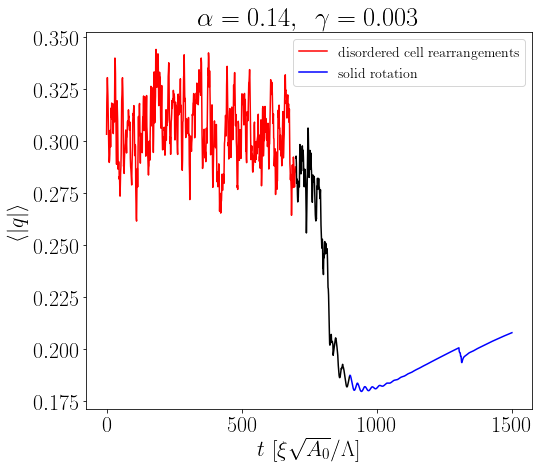

In [61]:
import matplotlib.pyplot as plt
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.size": 22
})

plt.close('all')
fig, ax = plt.subplots(1, 1, figsize=(8,7))
#------------------------------------------

#base_folder1 = "/data/biophys/aamiri/y2021/projects/organoids/rotationDraft/alpha_gamma_2/Nc200/r0/output_alpha_0.14_gamma_0.0_lambda0/elongations/"
#base_folder2 = "/data/biophys/aamiri/y2021/projects/organoids/rotationDraft/alpha_gamma_2/Nc200/r0/output_alpha_0.14_gamma_0.001_lambda0/elongations/"
#base_folder3 = "/data/biophys/aamiri/y2021/projects/organoids/rotationDraft/alpha_gamma_2/Nc200/r0/output_alpha_0.14_gamma_0.002_lambda0/elongations/"
base_folder4 = "/data/biophys/aamiri/y2021/projects/organoids/rotationDraft/alpha_gamma_2/Nc200/r0/output_alpha_0.14_gamma_0.003_lambda0/elongations/"
#base_folder5 = "/data/biophys/aamiri/y2021/projects/organoids/rotationDraft/alpha_gamma_2/Nc200/r1/output_alpha_0.14_gamma_0.004_lambda0/elongations/"
#base_folder6 = "/data/biophys/aamiri/y2021/projects/organoids/rotationDraft/alpha_gamma_2/Nc200/r0/output_alpha_0.14_gamma_0.005_lambda0/elongations/"
q_vals4 = []
for fr in np.arange(1000,2500):
#     q1 = np.loadtxt(base_folder1+"cells_q_eigen_vals_"+str(fr)+".txt")
#     q2 = np.loadtxt(base_folder2+"cells_q_eigen_vals_"+str(fr)+".txt")
#     q3 = np.loadtxt(base_folder3+"cells_q_eigen_vals_"+str(fr)+".txt")
    q4 = np.loadtxt(base_folder4+"cells_q_eigen_vals_"+str(fr)+".txt")
#     q5 = np.loadtxt(base_folder5+"cells_q_eigen_vals_"+str(fr)+".txt")
#     q6 = np.loadtxt(base_folder6+"cells_q_eigen_vals_"+str(fr)+".txt")
#     q_vals1.append(np.mean(q1))
#     q_vals2.append(np.mean(q2))
#     q_vals3.append(np.mean(q3))
    q_vals4.append(np.mean(q4))
#     q_vals5.append(np.mean(q5))
#     q_vals6.append(np.mean(q6))
    
# ax.plot(q_vals1, label="$\\gamma = 0$")
# ax.plot(q_vals2, label="$\\gamma = 0.001$")
# ax.plot(q_vals3, label="$\\gamma = 0.002$")
# ax.plot(q_vals4, label="$\\gamma = 0.003$")
# ax.plot(q_vals5, label="$\\gamma = 0.004$")
# ax.plot(q_vals6, label="$\\gamma = 0.005$")

t = range(len(q_vals4))
ax.plot(t[0:700], q_vals4[0:700], "r", label="$\\textrm{disordered cell rearrangements}$")
ax.plot(t[700:900], q_vals4[700:900], "k")
ax.plot(t[900:], q_vals4[900:], "b", label="$\\textrm{solid rotation}$")
plt.title("$\\alpha=0.14, \,\,\, \\gamma = 0.003$")
ax.set_xlabel("$t \\,\\,[\\xi \\sqrt{A_0}/\\Lambda]$")
ax.set_ylabel("$\\langle|q|\\rangle$")
plt.legend(fontsize=14)
plt.tight_layout()
plt.savefig("/home/aamiri/Desktop/norm_q_alpha_0p14.pdf")

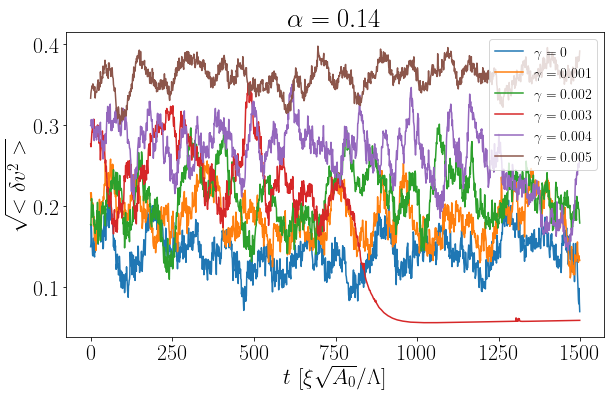

In [476]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.size": 22
})
plt.close('all')
fig, ax = plt.subplots(1, 1, figsize=(9,6))
#------------------------------------------

base_folder1 = "/data/biophys/aamiri/y2021/projects/organoids/rotationDraft/alpha_gamma_2/Nc200/r0/output_alpha_0.14_gamma_0.0_lambda0/rotation_output/"
base_folder2 = "/data/biophys/aamiri/y2021/projects/organoids/rotationDraft/alpha_gamma_2/Nc200/r0/output_alpha_0.14_gamma_0.001_lambda0/rotation_output/"
base_folder3 = "/data/biophys/aamiri/y2021/projects/organoids/rotationDraft/alpha_gamma_2/Nc200/r0/output_alpha_0.14_gamma_0.002_lambda0/rotation_output/"
base_folder4 = "/data/biophys/aamiri/y2021/projects/organoids/rotationDraft/alpha_gamma_2/Nc200/r0/output_alpha_0.14_gamma_0.003_lambda0/rotation_output/"
base_folder5 = "/data/biophys/aamiri/y2021/projects/organoids/rotationDraft/alpha_gamma_2/Nc200/r1/output_alpha_0.14_gamma_0.004_lambda0/rotation_output/"
base_folder6 = "/data/biophys/aamiri/y2021/projects/organoids/rotationDraft/alpha_gamma_2/Nc200/r0/output_alpha_0.14_gamma_0.005_lambda0/rotation_output/"

dv1 = np.loadtxt(base_folder1+"rms_delta_v.txt")
dv2 = np.loadtxt(base_folder2+"rms_delta_v.txt")
dv3 = np.loadtxt(base_folder3+"rms_delta_v.txt")
dv4 = np.loadtxt(base_folder4+"rms_delta_v.txt")
dv5 = np.loadtxt(base_folder5+"rms_delta_v.txt")
dv6 = np.loadtxt(base_folder6+"rms_delta_v.txt")
    
ax.plot(dv1, label="$\\gamma = 0$")
ax.plot(dv2, label="$\\gamma = 0.001$")
ax.plot(dv3, label="$\\gamma = 0.002$")
ax.plot(dv4, label="$\\gamma = 0.003$")
ax.plot(dv5, label="$\\gamma = 0.004$")
ax.plot(dv6, label="$\\gamma = 0.005$")

ax.set_xlabel("$t \\,\\,[\\xi \\sqrt{A_0}/\\Lambda]$")
ax.set_ylabel("$\\sqrt{<\\delta v^2>}$")
plt.title("$\\alpha=0.14$")
plt.legend(fontsize=14)
plt.tight_layout()
plt.savefig("/data/biophys/aamiri/y2021/projects/organoids/rotationDraft/alpha_gamma_2/Nc200/rms_dv.pdf")

### Slant

In [13]:
import sys
modules_address = "/data/biophys/aamiri/y2021/projects/organoids/rotationDraft/CurvedTM/curvedtm/"
modules_address2 = "/data/biophys/aamiri/y2021/projects/organoids/rotationDraft/CurvedTM/"
sys.path.append(modules_address)
sys.path.append(modules_address2)
import tools as MT


In [250]:
base_folder = "/data/biophys/aamiri/y2021/projects/organoids/rotationDraft/alpha_gamma_2/Nc200/r0/output_alpha_0.14_gamma_0.003_lambda0/"

data_folder_elong = base_folder + "elongations/"
data_folder_rotations = base_folder + "rotation_output/"

data_file_omega = data_folder_rotations + "Omega.txt"
omegas = np.loadtxt(data_file_omega)

it = 1000

cell_list=[]
with open(base_folder+"cells_"+str(it)+".txt") as f:
    [cell_list.append([int(i) for i in line.split()]) for line in f]
apic_points, tri, cell_cents = triangulate__apical_surface(vertex_points, cell_list)
cell_cents = np.array(cell_cents)
phi_hat = np.zeros(np.shape(cell_cents))
rr, tta, phi = cartesian_to_spherical(cell_cents[:,0], cell_cents[:,1], cell_cents[:,2])
phi_hat[:,0] = np.cos(tta)* np.cos(phi)
phi_hat[:,1] = np.cos(tta)* np.sin(phi)
phi_hat[:,2] = -np.sin(tta)
data_file_elong = data_folder_elong + "cells_q_eigen_vecs_" + str(it) + ".txt"
elong_eigen_vecs = np.loadtxt(data_file_elong)
Nc = len(elong_eigen_vecs)
omg = omegas[it]

ang = np.arccos(omg[2]/np.linalg.norm(omg))
rot_axis = np.cross(omg, np.array([0,0,1]))

rotated_q = MT.rotation(elong_eigen_vecs, np.repeat(ang, Nc), np.repeat([rot_axis/np.linalg.norm(rot_axis)], Nc, axis=0))
q_phi_angles = []
for ct in range(len(rotated_q)):
    rq = rotated_q[ct]
    rq = rq/np.linalg.norm(rq)
    ph = phi_hat[ct]
    ang1 = np.arccos(np.dot(ph, rq))
    ang2 = np.arccos(np.dot(ph, -rq))
    q_phi_angles.append([tta[ct], phi[ct], min(ang1, ang2)])
q_phi_angles = np.array(q_phi_angles)
#print(np.array(q_phi_angles))


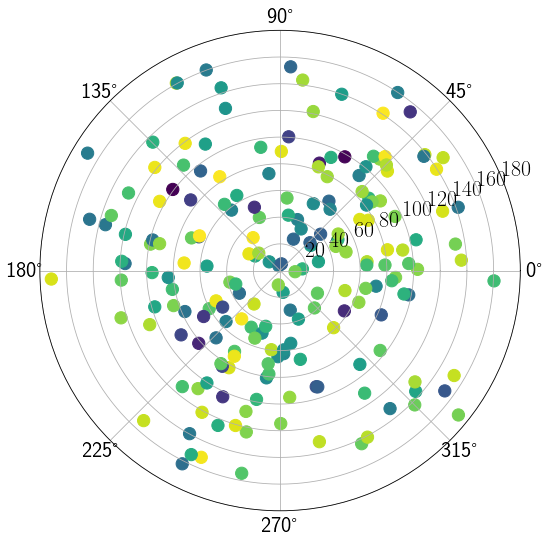

In [251]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.size": 22
})
fig, ax = plt.subplots(1, 1, figsize=(8,8))

ax = plt.subplot(111, polar=True)
col = q_phi_angles[:,2]
sc = ax.scatter(q_phi_angles[:,1], q_phi_angles[:,0]*180/np.pi, c=col, s=150)#, linewidth=3)
#plt.colorbar(sc, label="$t$")
ax.set_rmax(180)
# ax.set_rmin(70.0)
ax.grid(True)

#ax.set_title("Example", va='bottom')
plt.tight_layout()
plt.savefig("/data/biophys/aamiri/y2021/projects/organoids/rotationDraft/alpha_gamma/Nc200/slant_1000.pdf")

In [483]:
base_folder = "/data/biophys/aamiri/y2021/projects/organoids/rotationDraft/alpha_gamma_2/Nc200/r0/output_alpha_0.14_gamma_0.005_lambda0/"

data_folder_elong = base_folder + "elongations/"
data_folder_rotations = base_folder + "rotation_output/"

data_file_omega = data_folder_rotations + "Omega.txt"
omegas = np.loadtxt(data_file_omega)


all_q_phi_angles = np.array([[0,0,0]])
for it in range(2400, 2500-1, 1):
    cell_list=[]
    with open(base_folder+"cells_"+str(it)+".txt") as f:
        [cell_list.append([int(i) for i in line.split()]) for line in f]
    apic_points, tri, cell_cents = triangulate__apical_surface(vertex_points, cell_list)
    cell_cents = np.array(cell_cents)
    data_file_elong = data_folder_elong + "cells_q_eigen_vecs_" + str(it) + ".txt"
    elong_eigen_vecs = np.loadtxt(data_file_elong)
    Nc = len(elong_eigen_vecs)
    omg = omegas[it-1000]

    ang = np.arccos(omg[2]/np.linalg.norm(omg))
    rot_axis = np.cross(omg, np.array([0,0,1]))

    rotated_q = MT.rotation(elong_eigen_vecs, np.repeat(ang, Nc), np.repeat([rot_axis/np.linalg.norm(rot_axis)], Nc, axis=0))
    
    cell_cents = MT.rotation(cell_cents, np.repeat(ang, Nc), np.repeat([rot_axis/np.linalg.norm(rot_axis)], Nc, axis=0))
    rr, tta, phi = cartesian_to_spherical(cell_cents[:,0], cell_cents[:,1], cell_cents[:,2])
    phi_hat = np.zeros(np.shape(cell_cents))
    phi_hat[:,0] = np.cos(tta)* np.cos(phi)
    phi_hat[:,1] = np.cos(tta)* np.sin(phi)
    phi_hat[:,2] = -np.sin(tta)
    q_phi_angles = []
    for ct in range(len(rotated_q)):
        rq = rotated_q[ct]
        rq = rq/np.linalg.norm(rq)
        ph = phi_hat[ct]
        ang1 = np.arccos(np.dot(ph, rq))
        ang2 = np.arccos(np.dot(ph, -rq))
        q_phi_angles.append([tta[ct], phi[ct], min(ang1, ang2)])
    q_phi_angles = np.array(q_phi_angles)
    all_q_phi_angles = np.concatenate((all_q_phi_angles, q_phi_angles), axis=0)

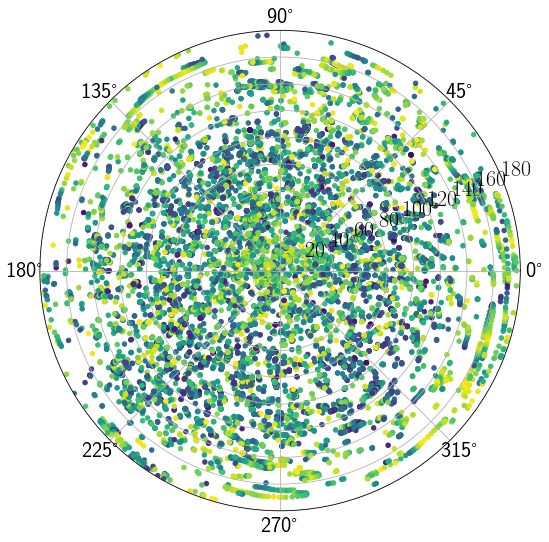

In [484]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.size": 22
})
fig, ax = plt.subplots(1, 1, figsize=(8,8))

ax = plt.subplot(111, polar=True)
col = all_q_phi_angles[:,2]
sc = ax.scatter(all_q_phi_angles[:,1], all_q_phi_angles[:,0]*180/np.pi, c=col, s=20)#, linewidth=3)
#plt.colorbar(sc, label="$t$")
ax.set_rmax(180)
# ax.set_rmin(70.0)
ax.grid(True)

#ax.set_title("Example", va='bottom')
plt.tight_layout()
#plt.savefig("/data/biophys/aamiri/y2021/projects/organoids/rotationDraft/alpha_gamma/Nc200/slant_alpha_0p125_gamma_0p004_from1800_2000.pdf")

In [194]:
base_folder = "/data/biophys/aamiri/y2021/projects/organoids/rotationDraft/alpha_gamma_2/Nc200/r0/output_alpha_0.14_gamma_0.003_lambda0/"

data_folder_elong = base_folder + "elongations/"
data_folder_rotations = base_folder + "rotation_output/"

data_file_omega = data_folder_rotations + "Omega.txt"
omegas = np.loadtxt(data_file_omega)

avg_omegas = np.mean(omegas[1100:1400], axis=0)
print(avg_omegas)
align_with_avg_omega = True

num_bins = 30
bins = np.linspace(0,np.pi, num_bins)
t_i, t_f = 1000, 2500-1
slant_grid = np.zeros((num_bins, t_f-t_i))
theta_elongation = {}

for it in range(t_i, t_f, 1):
    vertex_points = np.loadtxt(base_folder+"vertices_"+str(it)+".txt")
    cell_list=[]
    with open(base_folder+"cells_"+str(it)+".txt") as f:
        [cell_list.append([int(i) for i in line.split()]) for line in f]
    apic_points, tri, cell_cents = triangulate__apical_surface(vertex_points, cell_list)
    cell_cents = np.array(cell_cents)
    data_file_elong = data_folder_elong + "cells_q_eigen_vecs_" + str(it) + ".txt"
    elong_eigen_vecs = np.loadtxt(data_file_elong)
    data_file_elong_norm = data_folder_elong + "cells_q_eigen_vals_" + str(it) + ".txt"
    elong_eigen_vals = np.loadtxt(data_file_elong_norm)
    #print(len(elong_eigen_vals))
    Nc = len(elong_eigen_vecs)
    if align_with_avg_omega:
        omg = avg_omegas
    else:
        omg = omegas[it-t_i]
    #omg = np.mean(omegas, axis=0)

    ang = np.arccos(omg[2]/np.linalg.norm(omg))
    rot_axis = np.cross(omg, np.array([0,0,1]))

    rotated_q = MT.rotation(elong_eigen_vecs, np.repeat(ang, Nc), np.repeat([rot_axis/np.linalg.norm(rot_axis)], Nc, axis=0))
    
    cell_cents = MT.rotation(cell_cents, np.repeat(ang, Nc), np.repeat([rot_axis/np.linalg.norm(rot_axis)], Nc, axis=0))
    rr, tta, phi = cartesian_to_spherical(cell_cents[:,0], cell_cents[:,1], cell_cents[:,2])
    phi_hat = np.zeros(np.shape(cell_cents))
    tta_hat = np.zeros(np.shape(cell_cents))
    phi_hat[:,0] = -np.sin(phi)
    phi_hat[:,1] = np.cos(phi)
    #phi_hat[:,2] = 0
    #...
    tta_hat[:,0] = np.cos(tta)* np.cos(phi)
    tta_hat[:,1] = np.cos(tta)* np.sin(phi)
    tta_hat[:,2] = -np.sin(tta)
    #...
    q_phi_angles = []
    for ct in range(len(rotated_q)):
        c_q_norm = elong_eigen_vals[ct]
        rq = rotated_q[ct]
        rq = rq/np.linalg.norm(rq)
        ph = phi_hat[ct]
        c_tta = tta_hat[ct]
        if np.arccos(np.dot(rq, c_tta))<np.pi/2.:
            rq = -rq
        ang1 = np.arccos(np.dot(ph, rq))
        #ang2 = np.arccos(np.dot(ph, -rq))
        #q_phi_angles.append([tta[ct], phi[ct], min(ang1, ang2)*c_q_norm])
        q_phi_angles.append([tta[ct], phi[ct], ang1, c_q_norm])
    q_phi_angles = np.array(q_phi_angles)
    #...
    hist_vals, hist_edges = np.histogram(q_phi_angles[:,2], bins= np.linspace(0, np.pi, num_bins +1))
    slant_grid[:,it-t_i] = hist_vals
    #...
    if it%100==0:
        theta_elongation["t="+str(it)] = [q_phi_angles[:,0], q_phi_angles[:,3], q_phi_angles[:,2]] # theta, |q|, beta
#     data = q_phi_angles[:,0]
#     digitized = np.digitize(data, bins)
#     slnt = q_phi_angles[:,2]
#     bin_means = [slnt[digitized==i].mean() for i in range(0,len(bins))]
#     slant_grid[:,it-t_i] = bin_means
#====================================================================


[0.08134496 0.00044111 0.16556704]


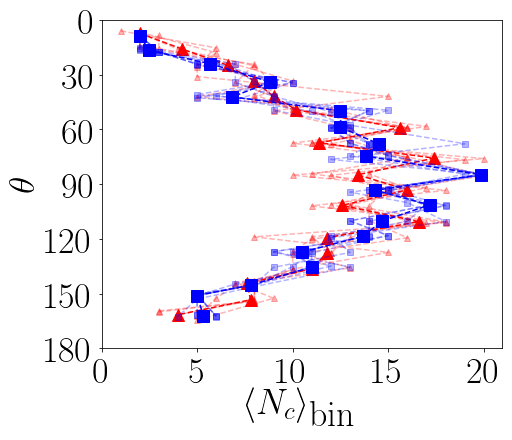

In [215]:
def bin_tta_profile(tta_vals, q_vals):
    bins = np.arange(0.2,np.pi-0.2,0.15)
    tta_binned = [np.nan]*len(bins)
    qs_binned = [np.nan]*len(bins)
    n_counts = [0]*len(bins)
    
    inds = np.digitize(tta_vals, bins)
    for i in range(len(bins)):
        bin_idx = inds==i
        n_counts[i] = sum(bin_idx)
        if n_counts[i]>0:
            tta_binned[i] = np.mean(tta_vals[bin_idx])
            qs_binned[i] = np.mean(q_vals[bin_idx])
    return np.array(tta_binned), np.array(qs_binned), n_counts

    
#=========================
plt.close('all')
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.size": 36
})
fig, ax = plt.subplots(1, 1, figsize=(8,7))


t_disordered = ['t=1000', 't=1100', 't=1200', 't=1300', 't=1400']
ttas_to_avg = []
qs_to_avg = []
nc_to_avg = []
for t in t_disordered:
    ttas = theta_elongation[t][0]
    qs = theta_elongation[t][1]
    tta_binned, qs_binned, nc_bins = bin_tta_profile(ttas, qs)  
    ax.plot(nc_bins, tta_binned*180/np.pi, 'r--^', alpha=0.3)
    ttas_to_avg.append(tta_binned)
    qs_to_avg.append(qs_binned)
    nc_to_avg.append(nc_bins)
nc_to_avg = np.array(nc_to_avg)
ttas_to_avg = np.array(ttas_to_avg)
qs_to_avg = np.array(qs_to_avg)
ax.plot(np.mean(nc_to_avg, axis=0), np.mean(ttas_to_avg, axis=0)*180/np.pi,'r--^', markersize=12 )

t_rotational = ['t=1900', 't=2000', 't=2100', 't=2200', 't=2300', 't=2400']
ttas_to_avg = []
qs_to_avg = []
nc_to_avg = []
for t in t_rotational:
    ttas = theta_elongation[t][0]
    qs = theta_elongation[t][1]
    tta_binned, qs_binned, nc_bins = bin_tta_profile(ttas, qs)  
    ax.plot(nc_bins, tta_binned*180/np.pi, 'b--s', alpha=0.3)
    ttas_to_avg.append(tta_binned)
    qs_to_avg.append(qs_binned)
    nc_to_avg.append(nc_bins)

nc_to_avg = np.array(nc_to_avg)
ttas_to_avg = np.array(ttas_to_avg)
qs_to_avg = np.array(qs_to_avg)

ax.plot(np.mean(nc_to_avg, axis=0), np.mean(ttas_to_avg, axis=0)*180/np.pi,'b--s', markersize=12 )

ax.set_xlabel("$\\langle N_c \\rangle_\\textrm{bin}$")
ax.set_ylabel("$\\theta$")
ax.set_ylim([0, 180])
ax.set_xticks(np.arange(0, 25, 5))
ax.set_yticks(np.arange(0, 190, 30))
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig("/home/aamiri/Desktop/tta_vs_Nc.pdf")

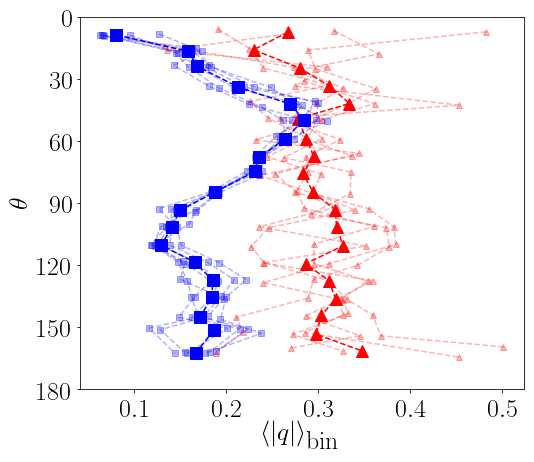

In [217]:
#=========================
plt.close('all')
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.size": 26
})
fig, ax = plt.subplots(1, 1, figsize=(8,7))


t_disordered = ['t=1000', 't=1100', 't=1200', 't=1300', 't=1400']
ttas_to_avg = []
qs_to_avg = []
nc_to_avg = []
for t in t_disordered:
    ttas = theta_elongation[t][0]
    qs = theta_elongation[t][1]
    tta_binned, qs_binned, nc_bins = bin_tta_profile(ttas, qs)  
    ax.plot(qs_binned, tta_binned*180/np.pi, 'r--^', alpha=0.3)
    ttas_to_avg.append(tta_binned)
    qs_to_avg.append(qs_binned)
    nc_to_avg.append(nc_bins)
ttas_to_avg = np.array(ttas_to_avg)
qs_to_avg = np.array(qs_to_avg)
ax.plot(np.mean(qs_to_avg, axis=0), np.mean(ttas_to_avg, axis=0)*180/np.pi,'r--^', markersize=12 )

t_rotational = ['t=1900', 't=2000', 't=2100', 't=2200', 't=2300', 't=2400']

ttas_to_avg = []
qs_to_avg = []
for t in t_rotational:
    ttas = theta_elongation[t][0]
    qs = theta_elongation[t][1]
    tta_binned, qs_binned, nc_bins = bin_tta_profile(ttas, qs)  
    ax.plot(qs_binned, tta_binned*180/np.pi, 'b--s', alpha=0.3)
    ttas_to_avg.append(tta_binned)
    qs_to_avg.append(qs_binned)
    
ttas_to_avg = np.array(ttas_to_avg)
qs_to_avg = np.array(qs_to_avg)

ax.plot(np.mean(qs_to_avg, axis=0), np.mean(ttas_to_avg, axis=0)*180/np.pi,'b--s', markersize=12 )

ax.set_xlabel("$\\langle |q| \\rangle_\\textrm{bin}$")
ax.set_ylabel("$\\theta$")
ax.set_ylim([0, 180])
ax.set_yticks(np.arange(0, 190, 30))
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig("/home/aamiri/Desktop/tta_vs_q.pdf")

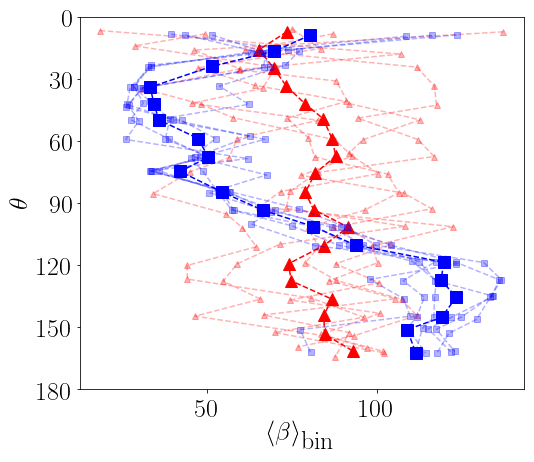

In [219]:
#=========================
plt.close('all')
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.size": 26
})
fig, ax = plt.subplots(1, 1, figsize=(8,7))


t_disordered = ['t=1000', 't=1100', 't=1200', 't=1300', 't=1400']
ttas_to_avg = []
betas_to_avg = []
for t in t_disordered:
    ttas = theta_elongation[t][0]
    betas = theta_elongation[t][2]
    tta_binned, betas_binned, n_bins = bin_tta_profile(ttas, betas)  
    ax.plot(betas_binned*180/np.pi, tta_binned*180/np.pi, 'r--^', alpha=0.3)
    ttas_to_avg.append(tta_binned)
    betas_to_avg.append(betas_binned)

ttas_to_avg = np.array(ttas_to_avg)
betas_to_avg = np.array(betas_to_avg)
ax.plot(np.mean(betas_to_avg, axis=0)*180/np.pi, np.mean(ttas_to_avg, axis=0)*180/np.pi,'r--^', markersize=12 )

t_rotational = ['t=1900', 't=2000', 't=2100', 't=2200', 't=2300', 't=2400']
ttas_to_avg = []
betas_to_avg = []
for t in t_rotational:
    ttas = theta_elongation[t][0]
    betas = theta_elongation[t][2]
    tta_binned, betas_binned, n_bins = bin_tta_profile(ttas, betas)  
    ax.plot(betas_binned*180/np.pi, tta_binned*180/np.pi, 'b--s', alpha=0.3)
    ttas_to_avg.append(tta_binned)
    betas_to_avg.append(betas_binned)
    
ttas_to_avg = np.array(ttas_to_avg)
betas_to_avg = np.array(betas_to_avg)
ax.plot(np.mean(betas_to_avg, axis=0)*180/np.pi, np.mean(ttas_to_avg, axis=0)*180/np.pi,'b--s', markersize=12 )

ax.set_xlabel("$\\langle \\beta \\rangle_\\textrm{bin}$")
ax.set_ylabel("$\\theta$")
ax.set_ylim([0, 180])
ax.set_yticks(np.arange(0, 190, 30))
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig("/home/aamiri/Desktop/tta_vs_beta.pdf")

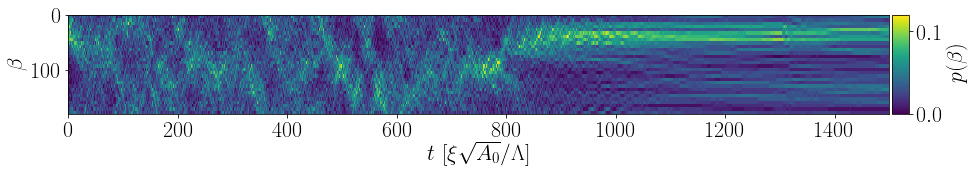

In [232]:
#====================================================================
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.size": 22
})
fig, ax = plt.subplots(1, 1, figsize=(14,3))

im = ax.imshow(slant_grid/200, extent=[0, t_f-t_i,180, 0])

#ax.axes.xaxis.set_visible(False)
#ax.axes.yaxis.set_visible(False)
ax.set_xlabel("$t \\,\\,[\\xi \\sqrt{A_0}/\\Lambda]$")
ax.set_ylabel("$\\beta$")

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="2%", pad=0.05)
   
plt.colorbar(im, cax=cax, label="$p(\\beta)$")

plt.tight_layout()
plt.savefig("/home/aamiri/Desktop/r0_slant_avg.pdf")
#plt.savefig(base_folder + "elongations/slant_avg.pdf")


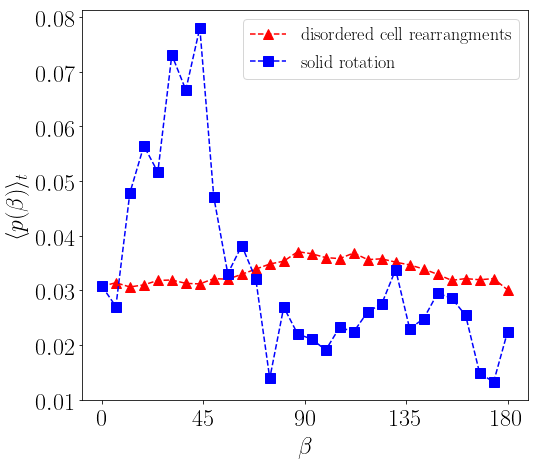

In [230]:

plt.close('all')
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.size": 24
})
fig, ax = plt.subplots(1, 1, figsize=(8,7))

plt.plot(np.linspace(0, np.pi, num_bins)*180./np.pi,
         np.mean(slant_grid[:,0:700]/200, axis= 1), 'r--^', markersize=10, label="$\\textrm{disordered cell rearrangments}$")

plt.plot(np.linspace(0, np.pi, num_bins)*180./np.pi,
         np.mean(slant_grid[:,950:]/200, axis= 1), 'b--s', markersize=10, label="$\\textrm{solid rotation}$")


ax.set_xlabel("$\\beta$")
ax.set_ylabel("$\\langle p(\\beta) \\rangle_t$")
plt.legend(fontsize=18)
ax.set_xticks(np.arange(0, 190, 45))
plt.tight_layout()
plt.savefig("/home/aamiri/Desktop/slant_avg_mean_r0.pdf")
#plt.savefig(base_folder + "elongations/slant_sum_avg.pdf")


# plt.close('all')
# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "sans-serif",
#     "font.size": 22
# })
# fig, ax = plt.subplots(1, 1, figsize=(8,7))

# plt.plot(np.linspace(0, np.pi, num_bins)*180./np.pi,
#          np.mean(slant_grid[:,0:100], axis= 1), label="$\\textrm{0 - 100}$")

# plt.plot(np.linspace(0, np.pi, num_bins)*180./np.pi,
#          np.mean(slant_grid[:,200:550], axis= 1), label="$\\textrm{200-550}$")

# plt.plot(np.linspace(0, np.pi, num_bins)*180./np.pi,
#          np.mean(slant_grid[:,650:850], axis= 1), label="$\\textrm{650-850}$")

# plt.plot(np.linspace(0, np.pi, num_bins)*180./np.pi,
#          np.mean(slant_grid[:,950:], axis= 1), label="$\\textrm{950 - 1500}$")

# ax.set_xlabel("$\\beta$")
# ax.set_ylabel("$\\langle N \\rangle$")
# plt.legend(fontsize=18)
# plt.tight_layout()
# plt.savefig("/home/aamiri/Desktop/r1/slant_avg_mean_r1.pdf")
# #plt.savefig(base_folder + "elongations/slant_sum_avg.pdf")

(30, 1499)


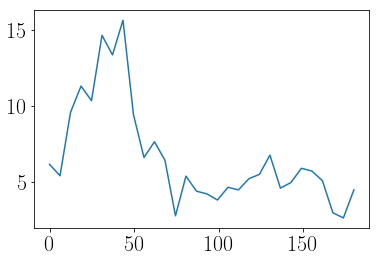

In [193]:
np.savetxt("/home/aamiri/Desktop/slant_grid_slide1.txt", slant_grid, fmt="%.2f")
a = np.loadtxt("/home/aamiri/Desktop/slant_grid_slide1.txt")
print(np.shape(a))
plt.plot(np.linspace(0, np.pi, num_bins)*180./np.pi,
         np.mean(slant_grid[:,950:], axis= 1), label="$\\textrm{950 - 1500}$")
#==========
# plt.close('all')
# base_folder = "/data/biophys/aamiri/y2021/projects/organoids/rotationDraft/alpha_gamma_2/Nc200/r1/output_alpha_0.14_gamma_0.003_lambda0/"
# data_folder_rotations = base_folder + "rotation_output/"

# data_file_omega = data_folder_rotations + "Omega.txt"
# omegas4 = np.loadtxt(data_file_omega)
# plt.plot(np.linalg.norm(omegas4, axis=1))

### realisation r1

In [647]:
#base_folder = "/data/biophys/aamiri/y2021/projects/organoids/rotationDraft/alpha_gamma_2/Nc200/r0/output_alpha_0.08_gamma_0.003_lambda0/"
base_folder = "/data/biophys/aamiri/y2021/projects/organoids/rotationDraft/alpha_gamma_2/growth/r4/output_alpha_0.08_gamma_0.003_lambda0/"
data_folder_elong = base_folder + "elongations/"
data_folder_rotations = base_folder + "rotation_output/"

data_file_omega = data_folder_rotations + "Omega.txt"
omegas = np.loadtxt(data_file_omega)

print(np.shape(omegas))


avg_omegas = np.mean(omegas[600:800], axis=0)
print(avg_omegas)
align_with_avg_omega = True

num_bins = 30
bins = np.linspace(0,np.pi, num_bins)
t_i, t_f = 400, 2000-1
slant_grid = np.zeros((num_bins, t_f-t_i))

marking_times = [40, 80, 250, 400, 700, 1000, 1100, 1200]
theta_elongation = {}

for it in range(t_i, t_f, 1):
    vertex_points = np.loadtxt(base_folder+"vertices_"+str(it)+".txt")
    cell_list=[]
    with open(base_folder+"cells_"+str(it)+".txt") as f:
        [cell_list.append([int(i) for i in line.split()]) for line in f]
    apic_points, tri, cell_cents = triangulate__apical_surface(vertex_points, cell_list)
    cell_cents = np.array(cell_cents)
    data_file_elong = data_folder_elong + "cells_q_eigen_vecs_" + str(it) + ".txt"
    elong_eigen_vecs = np.loadtxt(data_file_elong)
    data_file_elong_norm = data_folder_elong + "cells_q_eigen_vals_" + str(it) + ".txt"
    elong_eigen_vals = np.loadtxt(data_file_elong_norm)
    #print(len(elong_eigen_vals))
    Nc = len(elong_eigen_vecs)
    if align_with_avg_omega:
        omg = avg_omegas
    else:
        omg = omegas[it-t_i]
    #omg = np.mean(omegas, axis=0)

    ang = np.arccos(omg[2]/np.linalg.norm(omg))
    rot_axis = np.cross(omg, np.array([0,0,1]))

    rotated_q = MT.rotation(elong_eigen_vecs, np.repeat(ang, Nc), np.repeat([rot_axis/np.linalg.norm(rot_axis)], Nc, axis=0))
    
    cell_cents = MT.rotation(cell_cents, np.repeat(ang, Nc), np.repeat([rot_axis/np.linalg.norm(rot_axis)], Nc, axis=0))
    rr, tta, phi = cartesian_to_spherical(cell_cents[:,0], cell_cents[:,1], cell_cents[:,2])
    phi_hat = np.zeros(np.shape(cell_cents))
    tta_hat = np.zeros(np.shape(cell_cents))
    phi_hat[:,0] = -np.sin(phi)
    phi_hat[:,1] = np.cos(phi)
    #phi_hat[:,2] = 0
    #...
    tta_hat[:,0] = np.cos(tta)* np.cos(phi)
    tta_hat[:,1] = np.cos(tta)* np.sin(phi)
    tta_hat[:,2] = -np.sin(tta)
    #...
    q_phi_angles = []
    for ct in range(len(rotated_q)):
        c_q_norm = elong_eigen_vals[ct]
        rq = rotated_q[ct]
        rq = rq/np.linalg.norm(rq)
        ph = phi_hat[ct]
        c_tta = tta_hat[ct]
        if np.arccos(np.dot(rq, c_tta))<np.pi/2.:
            rq = -rq
        ang1 = np.arccos(np.dot(ph, rq))
        #ang2 = np.arccos(np.dot(ph, -rq))
        #q_phi_angles.append([tta[ct], phi[ct], min(ang1, ang2)*c_q_norm])
        q_phi_angles.append([tta[ct], phi[ct], ang1, c_q_norm])
    q_phi_angles = np.array(q_phi_angles)
    #...
    hist_vals, hist_edges = np.histogram(q_phi_angles[:,2], bins= np.linspace(0, np.pi, num_bins +1))
    slant_grid[:,it-t_i] = hist_vals
    #...
    if it%10==0:
        theta_elongation["t="+str(it-1000)] = [q_phi_angles[:,0], q_phi_angles[:,3], q_phi_angles[:,2]] # theta, |q|, beta
        
#slant_grid_alpha_0p08_gamma_0p003 = slant_grid

(1599, 3)
[ 0.01720704 -0.04780829 -0.01272525]


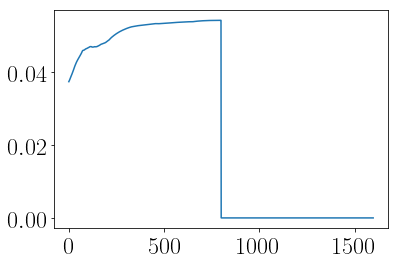

In [495]:
plt.plot(lin.norm(omegas, axis=1))

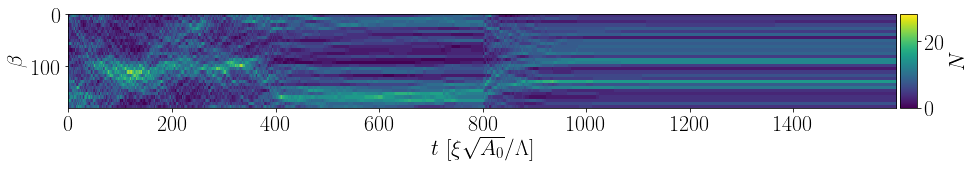

In [648]:
#====================================================================
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.size": 22
})
fig, ax = plt.subplots(1, 1, figsize=(14,8))

im = ax.imshow(slant_grid, extent=[0, t_f-t_i,180, 0])

#ax.axes.xaxis.set_visible(False)
#ax.axes.yaxis.set_visible(False)
ax.set_xlabel("$t \\,\\,[\\xi \\sqrt{A_0}/\\Lambda]$")
ax.set_ylabel("$\\beta$")

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="2%", pad=0.05)
   
plt.colorbar(im, cax=cax, label="$N$")

plt.tight_layout()
plt.savefig("/data/biophys/aamiri/y2021/projects/organoids/rotationDraft/alpha_gamma_2/growth/r4_alpha_0p08_gamma_0p003_to_stop_slant_avg_growth.pdf")

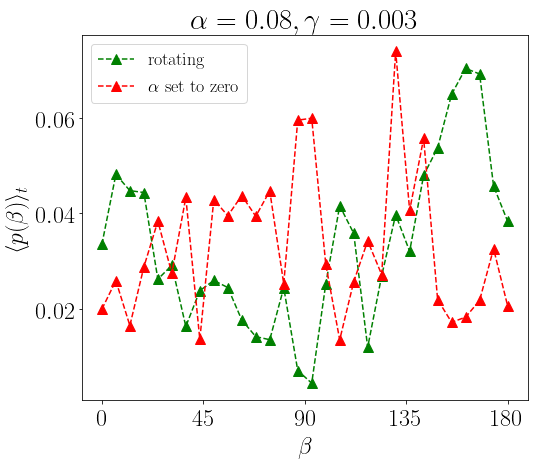

In [649]:

plt.close('all')
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.size": 24
})
fig, ax = plt.subplots(1, 1, figsize=(8,7))

plt.plot(np.linspace(0, np.pi, num_bins)*180./np.pi,
         np.mean(slant_grid[:,400:800]/200, axis= 1), 'g--^', markersize=10, label="$\\textrm{rotating}$")

plt.plot(np.linspace(0, np.pi, num_bins)*180./np.pi,
         np.mean(slant_grid[:,810:]/200, axis= 1), 'r--^', markersize=10, label="$\\alpha \\textrm{ set to zero}$")


ax.set_xlabel("$\\beta$")
ax.set_ylabel("$\\langle p(\\beta) \\rangle_t$")
plt.legend(fontsize=18)
ax.set_xticks(np.arange(0, 190, 45))
plt.title("$\\alpha=0.08, \\gamma=0.003$")
plt.tight_layout()
plt.savefig("/data/biophys/aamiri/y2021/projects/organoids/rotationDraft/alpha_gamma_2/growth/r4_slant_avg_mean_alpha0p08_gamma_0p003_to_stop.pdf")

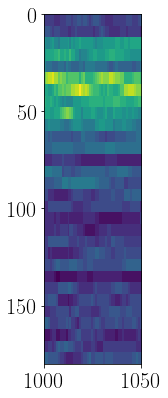

In [236]:
fig, ax = plt.subplots(1, 1, figsize=(4,6))

im = ax.imshow(slant_grid[:,1000:1050], extent=[1000,1050,180, 0])
#im = ax.imshow(slant_grid[:,600:700], extent=[600, 700,180, 0])


#ax.axes.xaxis.set_visible(False)
#ax.axes.yaxis.set_visible(False)
#ax.set_xlabel("$t \\,\\,[\\xi \\sqrt{A_0}/\\Lambda]$")
#ax.set_ylabel("$\\beta$")

#divider = make_axes_locatable(ax)
#cax = divider.append_axes("right", size="2%", pad=0.05)
   
plt.colorbar(im, cax=cax, label="$N$")

plt.tight_layout()

1499


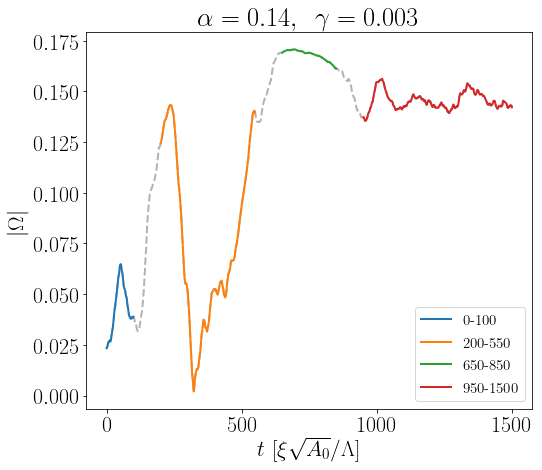

In [145]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.size": 22
})
fig, ax = plt.subplots(1, 1, figsize=(8,7))
#------------------------------------------

base_folder = "/data/biophys/aamiri/y2021/projects/organoids/rotationDraft/alpha_gamma_2/Nc200/r1/output_alpha_0.14_gamma_0.003_lambda0/"
data_folder_rotations = base_folder + "rotation_output/"

data_file_omega = data_folder_rotations + "Omega.txt"
omegas4 = np.loadtxt(data_file_omega)
t = range(len(omegas4))
print(len(omegas4))
ax.plot(t, np.linalg.norm(omegas4, axis=1), 'k--', linewidth=2, alpha=0.3)
ax.plot(t[0:100], np.linalg.norm(omegas4[0:100], axis=1), linewidth=2, label="$\\textrm{0-100}$")
ax.plot(t[200:550], np.linalg.norm(omegas4[200:550], axis=1), linewidth=2, label="$\\textrm{200-550}$")
ax.plot(t[650:850], np.linalg.norm(omegas4[650:850], axis=1), linewidth=2, label="$\\textrm{650-850}$")
ax.plot(t[950:1500], np.linalg.norm(omegas4[950:1500], axis=1), linewidth=2, label="$\\textrm{950-1500}$")

ax.set_xlabel("$t \\,\\,[\\xi \\sqrt{A_0}/\\Lambda]$")
ax.set_ylabel("$|\\Omega|$")
plt.title("$\\alpha=0.14,\,\,\, \\gamma = 0.003$")
plt.legend(fontsize=15)
plt.tight_layout()
plt.savefig("/home/aamiri/Desktop/r1/norm_omega_alpha0p14.pdf")

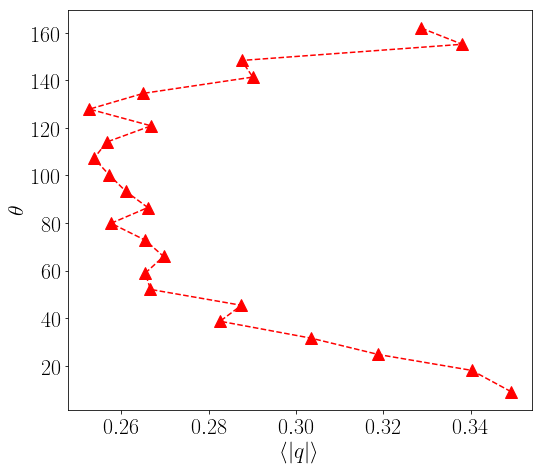

In [164]:
def bin_tta_profile(tta_vals, q_vals):
    bins = np.arange(0.25,np.pi-0.25,0.12)
    tta_binned = [np.nan]*len(bins)
    qs_binned = [np.nan]*len(bins)
    
    inds = np.digitize(tta_vals, bins)
    for i in range(len(bins)):
        bin_idx = inds==i
        if sum(bin_idx)>0:
            tta_binned[i] = np.mean(tta_vals[bin_idx])
            qs_binned[i] = np.mean(q_vals[bin_idx])
    return np.array(tta_binned), np.array(qs_binned)

    
#=========================
plt.close('all')
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.size": 22
})
fig, ax = plt.subplots(1, 1, figsize=(8,7))


ttas_to_avg = []
qs_to_avg = []
for f in np.arange(950,1500,10):#marking_times2:
    t = 't='+str(f)
    ttas = theta_elongation[t][0]
    qs = theta_elongation[t][1]
    tta_binned, qs_binned = bin_tta_profile(ttas, qs)  
    #ax.plot(qs_binned, tta_binned*180/np.pi, '--s', alpha=0.3)
    ttas_to_avg.append(tta_binned)
    qs_to_avg.append(qs_binned)
ttas_to_avg = np.array(ttas_to_avg)
qs_to_avg = np.array(qs_to_avg)
ax.plot(np.mean(qs_to_avg, axis=0), np.mean(ttas_to_avg, axis=0)*180/np.pi,'r--^', markersize=12 )

# #---------
# ttas_to_avg = []
# qs_to_avg = []
# for f in np.arange(50,90,10):#marking_times2:
#     t = 't='+str(f)
#     ttas = theta_elongation[t][0]
#     qs = theta_elongation[t][1]
#     tta_binned, qs_binned = bin_tta_profile(ttas, qs)  
#     #ax.plot(qs_binned, tta_binned*180/np.pi, '--s', alpha=0.3)
#     ttas_to_avg.append(tta_binned)
#     qs_to_avg.append(qs_binned)
# ttas_to_avg = np.array(ttas_to_avg)
# qs_to_avg = np.array(qs_to_avg)
# ax.plot(np.mean(qs_to_avg, axis=0), np.mean(ttas_to_avg, axis=0)*180/np.pi,'b--s', markersize=12 )

ax.set_xlabel("$\\langle |q| \\rangle$")
ax.set_ylabel("$\\theta$")
plt.tight_layout()
plt.savefig("/home/aamiri/Desktop/r1/tta_vs_q.pdf")

### $\alpha=0.08$

In [296]:
write_folder = "/data/biophys/aamiri/y2021/projects/organoids/rotationDraft/alpha_gamma/rotated_example_alpha0p125_gamma0p005/"
#.....................
base_folder = "/data/biophys/aamiri/y2021/projects/organoids/rotationDraft/alpha_gamma/Nc200/r0/output_alpha_0.125_gamma_0.004_lambda0/"

data_folder_elong = base_folder + "elongations/"
data_folder_rotations = base_folder + "rotation_output/"

data_file_omega = data_folder_rotations + "Omega.txt"
omegas = np.loadtxt(data_file_omega)


#...........
for it in np.arange(500,2000,1):
    print(it, end="\r")#sep=' ', end=' ', flush=True)
    eigen_vals = data_folder_elong + "cells_q_eigen_vals_" + str(it) + ".txt"
    data_file_elong = data_folder_elong + "cells_q_eigen_vecs_" + str(it) + ".txt"
    elong_eigen_vecs = np.loadtxt(data_file_elong)
    Nc = len(elong_eigen_vecs)
    omg = omegas[it]
    ang = np.arccos(omg[2]/np.linalg.norm(omg))
    rot_axis = np.cross(omg, np.array([0,0,1]))

    rotated_q = MT.rotation(elong_eigen_vecs, np.repeat(ang, Nc), np.repeat([rot_axis/np.linalg.norm(rot_axis)], Nc, axis=0))
    rot_polarity = MT.rotation(cell_data[:,1:4], np.repeat(ang, Nc), np.repeat([rot_axis/np.linalg.norm(rot_axis)], Nc, axis=0))
    
    vertex_points = np.loadtxt(base_folder+"vertices_"+str(it)+".txt")
    Nv = len(vertex_points)
    vertex_coords = vertex_points[:,0:3]
    vertex_coords = MT.rotation(vertex_coords, np.repeat(ang, Nv), np.repeat([rot_axis/np.linalg.norm(rot_axis)], Nv, axis=0))
    vertex_points[:,0:3] = vertex_coords
    cell_data = np.loadtxt(base_folder+"cell_data_"+str(it)+".txt")
    cell_list = []
    with open(base_folder+"cells_"+str(it)+".txt") as f:
        [cell_list.append([int(i) for i in line.split()]) for line in f]
    apic_points, tri, cell_cents = triangulate__apical_surface(vertex_points, cell_list)
    #print(len(eigen_vals))
    write_polygonal_mesh_to_vtk(write_folder+"polygons"+str(it), vertex_points[:,0:3], cell_list, cell_data)
    write_triangular_mesh_to_vtk(write_folder+"triangles"+str(it), apic_points, tri)
    write_vector_fields(write_folder+"polarity"+str(it), cell_cents, cell_data[:,0], "polyclass", rot_polarity, "polarity")
    write_vector_fields(write_folder+"q_tesnor"+str(it), cell_cents, np.linalg.norm(rotated_q, axis=1), "q", rotated_q, "q_vec")
#.............


IndexError: index 1999 is out of bounds for axis 0 with size 1999

### $<Q_1>$, $<Q_2>$, and ...

In [652]:
#base_folder = "/data/biophys/aamiri/y2021/projects/organoids/rotationDraft/alpha_gamma_2/Nc200/r0/output_alpha_0.14_gamma_0.003_lambda0/"
base_folder = "/data/biophys/aamiri/y2021/projects/organoids/rotationDraft/alpha_gamma_2/growth/r4/output_alpha_0.08_gamma_0.003_lambda0/"

data_folder_elong = base_folder + "elongations/"
data_folder_rotations = base_folder + "rotation_output/"

data_file_omega = data_folder_rotations + "Omega.txt"
omegas = np.loadtxt(data_file_omega)

avg_omegas = np.mean(omegas[600:800], axis=0)
print(avg_omegas)
align_with_avg_omega = True

num_bins = 30
bins = np.linspace(0,np.pi, num_bins)
t_i, t_f = 400, 2000-1


avg_Q1_t = []
avg_Q2_t = []
avg_norm_q_t = []
for it in range(t_i, t_f, 1):
    vertex_points = np.loadtxt(base_folder+"vertices_"+str(it)+".txt")
    cell_list=[]
    with open(base_folder+"cells_"+str(it)+".txt") as f:
        [cell_list.append([int(i) for i in line.split()]) for line in f]
    apic_points, tri, cell_cents = triangulate__apical_surface(vertex_points, cell_list)
    cell_cents = np.array(cell_cents)
    data_file_elong = data_folder_elong + "cells_q_eigen_vecs_" + str(it) + ".txt"
    elong_eigen_vecs = np.loadtxt(data_file_elong)
    data_file_elong_norm = data_folder_elong + "cells_q_eigen_vals_" + str(it) + ".txt"
    elong_eigen_vals = np.loadtxt(data_file_elong_norm)
    #print(len(elong_eigen_vals))
    Nc = len(elong_eigen_vecs)
    if align_with_avg_omega:
        omg = avg_omegas
    else:
        omg = omegas[it-t_i]
    #omg = np.mean(omegas, axis=0)

    ang = np.arccos(omg[2]/np.linalg.norm(omg))
    rot_axis = np.cross(omg, np.array([0,0,1]))

    rotated_q = MT.rotation(elong_eigen_vecs, np.repeat(ang, Nc), np.repeat([rot_axis/np.linalg.norm(rot_axis)], Nc, axis=0))
    
    cell_cents = MT.rotation(cell_cents, np.repeat(ang, Nc), np.repeat([rot_axis/np.linalg.norm(rot_axis)], Nc, axis=0))
    rr, tta, phi = cartesian_to_spherical(cell_cents[:,0], cell_cents[:,1], cell_cents[:,2])
    phi_hat = np.zeros(np.shape(cell_cents))
    tta_hat = np.zeros(np.shape(cell_cents))
    phi_hat[:,0] = -np.sin(phi)
    phi_hat[:,1] = np.cos(phi)
    #phi_hat[:,2] = 0
    #...
    tta_hat[:,0] = np.cos(tta)* np.cos(phi)
    tta_hat[:,1] = np.cos(tta)* np.sin(phi)
    tta_hat[:,2] = -np.sin(tta)
    #...
    #q_phi_angles = []
    cells_Q1, cells_Q2 = [0]*Nc, [0]*Nc
    for ct in range(len(rotated_q)):
        c_q_norm = elong_eigen_vals[ct]
        rq = rotated_q[ct]
        rq = rq/np.linalg.norm(rq)
        ph = phi_hat[ct]
        c_tta = tta_hat[ct]
        if np.arccos(np.dot(rq, c_tta))<np.pi/2.:
            rq = -rq
        beta_val = np.arccos(np.dot(ph, rq))
        Q1 = c_q_norm * np.cos(2.*beta_val)
        cells_Q1[ct] = Q1
        Q2 = c_q_norm * np.sin(2.*beta_val)
        cells_Q2[ct] = Q2
    avg_Q1_t.append(np.mean(np.array(cells_Q1)))
    avg_Q2_t.append(np.mean(np.array(cells_Q2)))
    avg_norm_q_t.append(np.mean(np.array(elong_eigen_vals)))


[ 0.01720704 -0.04780829 -0.01272525]


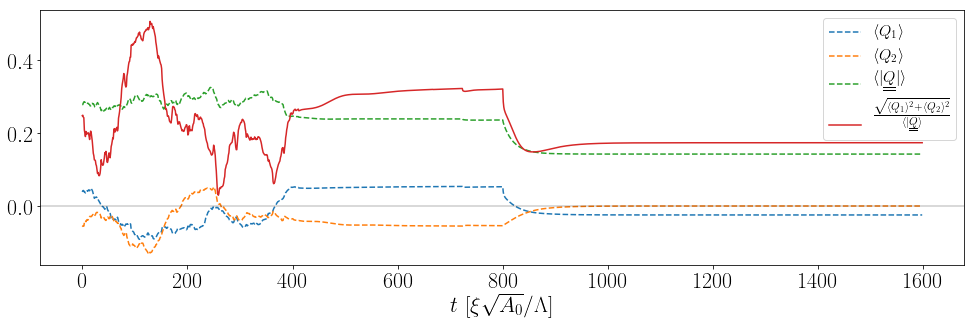

In [653]:
avg_Q1_t = np.array(avg_Q1_t)
avg_Q2_t = np.array(avg_Q2_t)
avg_norm_q_t = np.array(avg_norm_q_t)
#====================================================================
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.size": 22
})
fig, ax = plt.subplots(1, 1, figsize=(14,5))

QQ = np.sqrt(avg_Q1_t**2 + avg_Q2_t**2)/avg_norm_q_t

t = range(t_i-400, t_f-400, 1)

ax.plot(t, avg_Q1_t,'--', label="$\\langle Q_1\\rangle$")
ax.plot(t, avg_Q2_t,'--', label="$\\langle Q_2\\rangle$")
ax.plot(t, avg_norm_q_t,'--', label="$\\langle |\\underline{\\underline{Q}}|\\rangle$")
num = "\\sqrt{\\langle Q_1 \\rangle^2 + \\langle Q_2\\rangle^2}"
den = "\\langle |\\underline{\\underline{Q}}\\rangle"
ax.plot(t, QQ, label="$\\frac{"+num+"}{"+den+"}$")
ax.set_xlabel("$t \\,\\,[\\xi \\sqrt{A_0}/\\Lambda]$")
#ax.set_ylabel("$Q$")
plt.axhline(y=0, color='k', alpha=0.2)
plt.legend(fontsize=16)
plt.tight_layout()
plt.savefig("/data/biophys/aamiri/y2021/projects/organoids/rotationDraft/alpha_gamma_2/growth/r4_slant_Q1Q2_avg_axis.pdf")

In [285]:
base_folder = "/data/biophys/aamiri/y2021/projects/organoids/rotationDraft/alpha_gamma_2/Nc200/r0/output_alpha_0.14_gamma_0.003_lambda0/"

data_folder_elong = base_folder + "elongations/"
data_folder_rotations = base_folder + "rotation_output/"

data_file_omega = data_folder_rotations + "Omega.txt"
omegas = np.loadtxt(data_file_omega)

avg_omegas = np.mean(omegas[1100:1400], axis=0)
print(avg_omegas)
align_with_avg_omega = False

num_bins = 30
bins = np.linspace(0,np.pi, num_bins)
t_i, t_f = 1000, 2500-1


avg_Q1_t_cor = []
avg_Q2_t_cor = []
avg_norm_q_t_cor = []
for it in range(t_i, t_f, 1):
    vertex_points = np.loadtxt(base_folder+"vertices_"+str(it)+".txt")
    cell_list=[]
    with open(base_folder+"cells_"+str(it)+".txt") as f:
        [cell_list.append([int(i) for i in line.split()]) for line in f]
    apic_points, tri, cell_cents = triangulate__apical_surface(vertex_points, cell_list)
    cell_cents = np.array(cell_cents)
    data_file_elong = data_folder_elong + "cells_q_eigen_vecs_" + str(it) + ".txt"
    elong_eigen_vecs = np.loadtxt(data_file_elong)
    data_file_elong_norm = data_folder_elong + "cells_q_eigen_vals_" + str(it) + ".txt"
    elong_eigen_vals = np.loadtxt(data_file_elong_norm)
    #print(len(elong_eigen_vals))
    Nc = len(elong_eigen_vecs)
    if align_with_avg_omega:
        omg = avg_omegas
    else:
        omg = omegas[it-t_i]
    #omg = np.mean(omegas, axis=0)

    ang = np.arccos(omg[2]/np.linalg.norm(omg))
    rot_axis = np.cross(omg, np.array([0,0,1]))

    rotated_q = MT.rotation(elong_eigen_vecs, np.repeat(ang, Nc), np.repeat([rot_axis/np.linalg.norm(rot_axis)], Nc, axis=0))
    
    cell_cents = MT.rotation(cell_cents, np.repeat(ang, Nc), np.repeat([rot_axis/np.linalg.norm(rot_axis)], Nc, axis=0))
    rr, tta, phi = cartesian_to_spherical(cell_cents[:,0], cell_cents[:,1], cell_cents[:,2])
    phi_hat = np.zeros(np.shape(cell_cents))
    tta_hat = np.zeros(np.shape(cell_cents))
    phi_hat[:,0] = -np.sin(phi)
    phi_hat[:,1] = np.cos(phi)
    #phi_hat[:,2] = 0
    #...
    tta_hat[:,0] = np.cos(tta)* np.cos(phi)
    tta_hat[:,1] = np.cos(tta)* np.sin(phi)
    tta_hat[:,2] = -np.sin(tta)
    #...
    #q_phi_angles = []
    cells_Q1, cells_Q2 = [0]*Nc, [0]*Nc
    for ct in range(len(rotated_q)):
        c_q_norm = elong_eigen_vals[ct]
        rq = rotated_q[ct]
        rq = rq/np.linalg.norm(rq)
        ph = phi_hat[ct]
        c_tta = tta_hat[ct]
        if np.arccos(np.dot(rq, c_tta))<np.pi/2.:
            rq = -rq
        beta_val = np.arccos(np.dot(ph, rq))
        Q1 = c_q_norm * np.cos(2.*beta_val)
        cells_Q1[ct] = Q1
        Q2 = c_q_norm * np.sin(2.*beta_val)
        cells_Q2[ct] = Q2
    avg_Q1_t_cor.append(np.mean(np.array(cells_Q1)))
    avg_Q2_t_cor.append(np.mean(np.array(cells_Q2)))
    avg_norm_q_t_cor.append(np.mean(np.array(elong_eigen_vals)))

[0.08134496 0.00044111 0.16556704]


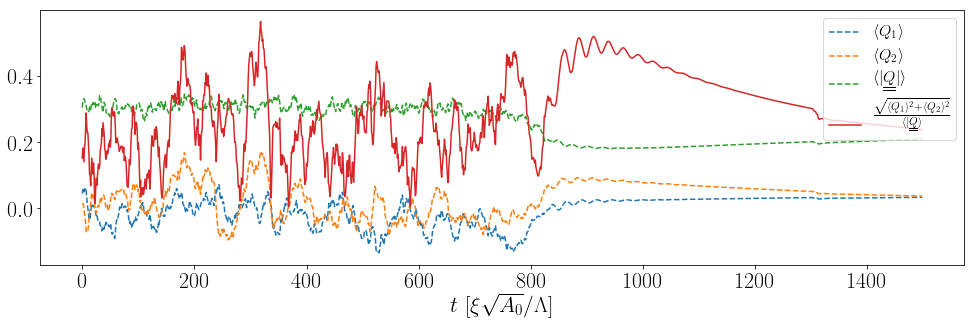

In [286]:
avg_Q1_t_cor = np.array(avg_Q1_t_cor)
avg_Q2_t_cor = np.array(avg_Q2_t_cor)
avg_norm_q_t_cor = np.array(avg_norm_q_t_cor)
#====================================================================
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.size": 22
})
fig, ax = plt.subplots(1, 1, figsize=(14,5))

QQ = np.sqrt(avg_Q1_t_cor**2 + avg_Q2_t_cor**2)/avg_norm_q_t_cor

t = range(t_i-1000, t_f-1000, 1)

ax.plot(t, avg_Q1_t_cor,'--', label="$\\langle Q_1\\rangle$")
ax.plot(t, avg_Q2_t_cor,'--', label="$\\langle Q_2\\rangle$")
ax.plot(t, avg_norm_q_t_cor,'--', label="$\\langle |\\underline{\\underline{Q}}|\\rangle$")
num = "\\sqrt{\\langle Q_1 \\rangle^2 + \\langle Q_2\\rangle^2}"
den = "\\langle |\\underline{\\underline{Q}}\\rangle"
ax.plot(t, QQ, label="$\\frac{"+num+"}{"+den+"}$")
ax.set_xlabel("$t \\,\\,[\\xi \\sqrt{A_0}/\\Lambda]$")
#ax.set_ylabel("$Q$")

plt.legend(fontsize=16)
plt.tight_layout()
plt.savefig("/home/aamiri/Desktop/slant_Q1Q2_cor_axis.pdf")

In [287]:
base_folder = "/data/biophys/aamiri/y2021/projects/organoids/rotationDraft/alpha_gamma_2/Nc200/r1/output_alpha_0.14_gamma_0.003_lambda0/"

data_folder_elong = base_folder + "elongations/"
data_folder_rotations = base_folder + "rotation_output/"

data_file_omega = data_folder_rotations + "Omega.txt"
omegas = np.loadtxt(data_file_omega)

avg_omegas = np.mean(omegas[650:850], axis=0)
print(avg_omegas)
align_with_avg_omega = True

num_bins = 30
bins = np.linspace(0,np.pi, num_bins)
t_i, t_f = 1000, 2500-1


avg_Q1_t = []
avg_Q2_t = []
avg_norm_q_t = []
for it in range(t_i, t_f, 1):
    vertex_points = np.loadtxt(base_folder+"vertices_"+str(it)+".txt")
    cell_list=[]
    with open(base_folder+"cells_"+str(it)+".txt") as f:
        [cell_list.append([int(i) for i in line.split()]) for line in f]
    apic_points, tri, cell_cents = triangulate__apical_surface(vertex_points, cell_list)
    cell_cents = np.array(cell_cents)
    data_file_elong = data_folder_elong + "cells_q_eigen_vecs_" + str(it) + ".txt"
    elong_eigen_vecs = np.loadtxt(data_file_elong)
    data_file_elong_norm = data_folder_elong + "cells_q_eigen_vals_" + str(it) + ".txt"
    elong_eigen_vals = np.loadtxt(data_file_elong_norm)
    #print(len(elong_eigen_vals))
    Nc = len(elong_eigen_vecs)
    if align_with_avg_omega:
        omg = avg_omegas
    else:
        omg = omegas[it-t_i]
    #omg = np.mean(omegas, axis=0)

    ang = np.arccos(omg[2]/np.linalg.norm(omg))
    rot_axis = np.cross(omg, np.array([0,0,1]))

    rotated_q = MT.rotation(elong_eigen_vecs, np.repeat(ang, Nc), np.repeat([rot_axis/np.linalg.norm(rot_axis)], Nc, axis=0))
    
    cell_cents = MT.rotation(cell_cents, np.repeat(ang, Nc), np.repeat([rot_axis/np.linalg.norm(rot_axis)], Nc, axis=0))
    rr, tta, phi = cartesian_to_spherical(cell_cents[:,0], cell_cents[:,1], cell_cents[:,2])
    phi_hat = np.zeros(np.shape(cell_cents))
    tta_hat = np.zeros(np.shape(cell_cents))
    phi_hat[:,0] = -np.sin(phi)
    phi_hat[:,1] = np.cos(phi)
    #phi_hat[:,2] = 0
    #...
    tta_hat[:,0] = np.cos(tta)* np.cos(phi)
    tta_hat[:,1] = np.cos(tta)* np.sin(phi)
    tta_hat[:,2] = -np.sin(tta)
    #...
    #q_phi_angles = []
    cells_Q1, cells_Q2 = [0]*Nc, [0]*Nc
    for ct in range(len(rotated_q)):
        c_q_norm = elong_eigen_vals[ct]
        rq = rotated_q[ct]
        rq = rq/np.linalg.norm(rq)
        ph = phi_hat[ct]
        c_tta = tta_hat[ct]
        if np.arccos(np.dot(rq, c_tta))<np.pi/2.:
            rq = -rq
        beta_val = np.arccos(np.dot(ph, rq))
        Q1 = c_q_norm * np.cos(2.*beta_val)
        cells_Q1[ct] = Q1
        Q2 = c_q_norm * np.sin(2.*beta_val)
        cells_Q2[ct] = Q2
    avg_Q1_t.append(np.mean(np.array(cells_Q1)))
    avg_Q2_t.append(np.mean(np.array(cells_Q2)))
    avg_norm_q_t.append(np.mean(np.array(elong_eigen_vals)))

[-0.1575051   0.05738984  0.00963559]


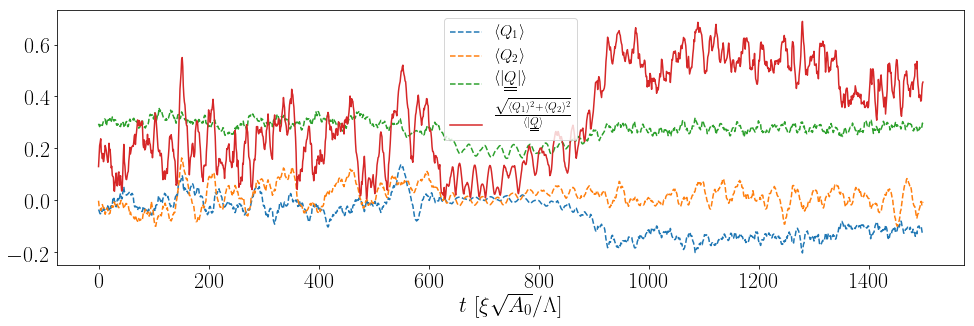

In [288]:
avg_Q1_t = np.array(avg_Q1_t)
avg_Q2_t = np.array(avg_Q2_t)
avg_norm_q_t = np.array(avg_norm_q_t)
#====================================================================
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.size": 22
})
fig, ax = plt.subplots(1, 1, figsize=(14,5))

QQ = np.sqrt(avg_Q1_t**2 + avg_Q2_t**2)/avg_norm_q_t

t = range(t_i-1000, t_f-1000, 1)

ax.plot(t, avg_Q1_t,'--', label="$\\langle Q_1\\rangle$")
ax.plot(t, avg_Q2_t,'--', label="$\\langle Q_2\\rangle$")
ax.plot(t, avg_norm_q_t,'--', label="$\\langle |\\underline{\\underline{Q}}|\\rangle$")
num = "\\sqrt{\\langle Q_1 \\rangle^2 + \\langle Q_2\\rangle^2}"
den = "\\langle |\\underline{\\underline{Q}}\\rangle"
ax.plot(t, QQ, label="$\\frac{"+num+"}{"+den+"}$")
ax.set_xlabel("$t \\,\\,[\\xi \\sqrt{A_0}/\\Lambda]$")
#ax.set_ylabel("$Q$")

plt.legend(fontsize=16)
plt.tight_layout()
plt.savefig("/home/aamiri/Desktop/r1_slant_Q1Q2_avg_axis.pdf")

### Now with respect to a random axis

In [297]:
base_folder = "/data/biophys/aamiri/y2021/projects/organoids/rotationDraft/alpha_gamma_2/Nc200/r0/output_alpha_0.14_gamma_0.003_lambda0/"

data_folder_elong = base_folder + "elongations/"
data_folder_rotations = base_folder + "rotation_output/"

data_file_omega = data_folder_rotations + "Omega.txt"
omegas = np.loadtxt(data_file_omega)

avg_omegas = np.random.rand(3)#np.mean(omegas[650:850], axis=0)
print(avg_omegas)
align_with_avg_omega = True

num_bins = 30
bins = np.linspace(0,np.pi, num_bins)
t_i, t_f = 1000, 2500-1


avg_Q1_t = []
avg_Q2_t = []
avg_norm_q_t = []
for it in range(t_i, t_f, 1):
    vertex_points = np.loadtxt(base_folder+"vertices_"+str(it)+".txt")
    cell_list=[]
    with open(base_folder+"cells_"+str(it)+".txt") as f:
        [cell_list.append([int(i) for i in line.split()]) for line in f]
    apic_points, tri, cell_cents = triangulate__apical_surface(vertex_points, cell_list)
    cell_cents = np.array(cell_cents)
    data_file_elong = data_folder_elong + "cells_q_eigen_vecs_" + str(it) + ".txt"
    elong_eigen_vecs = np.loadtxt(data_file_elong)
    data_file_elong_norm = data_folder_elong + "cells_q_eigen_vals_" + str(it) + ".txt"
    elong_eigen_vals = np.loadtxt(data_file_elong_norm)
    #print(len(elong_eigen_vals))
    Nc = len(elong_eigen_vecs)
    if align_with_avg_omega:
        omg = avg_omegas
    else:
        omg = omegas[it-t_i]
    #omg = np.mean(omegas, axis=0)

    ang = np.arccos(omg[2]/np.linalg.norm(omg))
    rot_axis = np.cross(omg, np.array([0,0,1]))

    rotated_q = MT.rotation(elong_eigen_vecs, np.repeat(ang, Nc), np.repeat([rot_axis/np.linalg.norm(rot_axis)], Nc, axis=0))
    
    cell_cents = MT.rotation(cell_cents, np.repeat(ang, Nc), np.repeat([rot_axis/np.linalg.norm(rot_axis)], Nc, axis=0))
    rr, tta, phi = cartesian_to_spherical(cell_cents[:,0], cell_cents[:,1], cell_cents[:,2])
    phi_hat = np.zeros(np.shape(cell_cents))
    tta_hat = np.zeros(np.shape(cell_cents))
    phi_hat[:,0] = -np.sin(phi)
    phi_hat[:,1] = np.cos(phi)
    #phi_hat[:,2] = 0
    #...
    tta_hat[:,0] = np.cos(tta)* np.cos(phi)
    tta_hat[:,1] = np.cos(tta)* np.sin(phi)
    tta_hat[:,2] = -np.sin(tta)
    #...
    #q_phi_angles = []
    cells_Q1, cells_Q2 = [0]*Nc, [0]*Nc
    for ct in range(len(rotated_q)):
        c_q_norm = elong_eigen_vals[ct]
        rq = rotated_q[ct]
        rq = rq/np.linalg.norm(rq)
        ph = phi_hat[ct]
        c_tta = tta_hat[ct]
        if np.arccos(np.dot(rq, c_tta))<np.pi/2.:
            rq = -rq
        beta_val = np.arccos(np.dot(ph, rq))
        Q1 = c_q_norm * np.cos(2.*beta_val)
        cells_Q1[ct] = Q1
        Q2 = c_q_norm * np.sin(2.*beta_val)
        cells_Q2[ct] = Q2
    avg_Q1_t.append(np.mean(np.array(cells_Q1)))
    avg_Q2_t.append(np.mean(np.array(cells_Q2)))
    avg_norm_q_t.append(np.mean(np.array(elong_eigen_vals)))

[0.18409701 0.59925243 0.09603211]


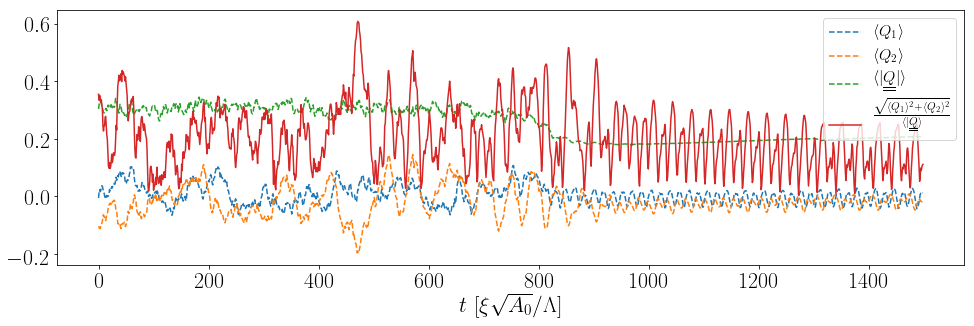

In [298]:
avg_Q1_t = np.array(avg_Q1_t)
avg_Q2_t = np.array(avg_Q2_t)
avg_norm_q_t = np.array(avg_norm_q_t)
#====================================================================
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.size": 22
})
fig, ax = plt.subplots(1, 1, figsize=(14,5))

QQ = np.sqrt(avg_Q1_t**2 + avg_Q2_t**2)/avg_norm_q_t

t = range(t_i-1000, t_f-1000, 1)

ax.plot(t, avg_Q1_t,'--', label="$\\langle Q_1\\rangle$")
ax.plot(t, avg_Q2_t,'--', label="$\\langle Q_2\\rangle$")
ax.plot(t, avg_norm_q_t,'--', label="$\\langle |\\underline{\\underline{Q}}|\\rangle$")
num = "\\sqrt{\\langle Q_1 \\rangle^2 + \\langle Q_2\\rangle^2}"
den = "\\langle |\\underline{\\underline{Q}}\\rangle"
ax.plot(t, QQ, label="$\\frac{"+num+"}{"+den+"}$")
ax.set_xlabel("$t \\,\\,[\\xi \\sqrt{A_0}/\\Lambda]$")
#ax.set_ylabel("$Q$")

plt.legend(fontsize=16)
plt.tight_layout()
plt.savefig("/home/aamiri/Desktop/r0_slant_Q1Q2_fixed_rand2_axis.pdf")

In [289]:
base_folder = "/data/biophys/aamiri/y2021/projects/organoids/rotationDraft/alpha_gamma_2/Nc200/r1/output_alpha_0.14_gamma_0.003_lambda0/"

data_folder_elong = base_folder + "elongations/"
data_folder_rotations = base_folder + "rotation_output/"

data_file_omega = data_folder_rotations + "Omega.txt"
omegas = np.loadtxt(data_file_omega)

avg_omegas = np.mean(omegas[1100:1400], axis=0)
print(avg_omegas)
align_with_avg_omega = False

num_bins = 30
bins = np.linspace(0,np.pi, num_bins)
t_i, t_f = 1000, 2500-1


avg_Q1_t_cor = []
avg_Q2_t_cor = []
avg_norm_q_t_cor = []
for it in range(t_i, t_f, 1):
    vertex_points = np.loadtxt(base_folder+"vertices_"+str(it)+".txt")
    cell_list=[]
    with open(base_folder+"cells_"+str(it)+".txt") as f:
        [cell_list.append([int(i) for i in line.split()]) for line in f]
    apic_points, tri, cell_cents = triangulate__apical_surface(vertex_points, cell_list)
    cell_cents = np.array(cell_cents)
    data_file_elong = data_folder_elong + "cells_q_eigen_vecs_" + str(it) + ".txt"
    elong_eigen_vecs = np.loadtxt(data_file_elong)
    data_file_elong_norm = data_folder_elong + "cells_q_eigen_vals_" + str(it) + ".txt"
    elong_eigen_vals = np.loadtxt(data_file_elong_norm)
    #print(len(elong_eigen_vals))
    Nc = len(elong_eigen_vecs)
    if align_with_avg_omega:
        omg = avg_omegas
    else:
        omg = omegas[it-t_i]
    #omg = np.mean(omegas, axis=0)

    ang = np.arccos(omg[2]/np.linalg.norm(omg))
    rot_axis = np.cross(omg, np.array([0,0,1]))

    rotated_q = MT.rotation(elong_eigen_vecs, np.repeat(ang, Nc), np.repeat([rot_axis/np.linalg.norm(rot_axis)], Nc, axis=0))
    
    cell_cents = MT.rotation(cell_cents, np.repeat(ang, Nc), np.repeat([rot_axis/np.linalg.norm(rot_axis)], Nc, axis=0))
    rr, tta, phi = cartesian_to_spherical(cell_cents[:,0], cell_cents[:,1], cell_cents[:,2])
    phi_hat = np.zeros(np.shape(cell_cents))
    tta_hat = np.zeros(np.shape(cell_cents))
    phi_hat[:,0] = -np.sin(phi)
    phi_hat[:,1] = np.cos(phi)
    #phi_hat[:,2] = 0
    #...
    tta_hat[:,0] = np.cos(tta)* np.cos(phi)
    tta_hat[:,1] = np.cos(tta)* np.sin(phi)
    tta_hat[:,2] = -np.sin(tta)
    #...
    #q_phi_angles = []
    cells_Q1, cells_Q2 = [0]*Nc, [0]*Nc
    for ct in range(len(rotated_q)):
        c_q_norm = elong_eigen_vals[ct]
        rq = rotated_q[ct]
        rq = rq/np.linalg.norm(rq)
        ph = phi_hat[ct]
        c_tta = tta_hat[ct]
        if np.arccos(np.dot(rq, c_tta))<np.pi/2.:
            rq = -rq
        beta_val = np.arccos(np.dot(ph, rq))
        Q1 = c_q_norm * np.cos(2.*beta_val)
        cells_Q1[ct] = Q1
        Q2 = c_q_norm * np.sin(2.*beta_val)
        cells_Q2[ct] = Q2
    avg_Q1_t_cor.append(np.mean(np.array(cells_Q1)))
    avg_Q2_t_cor.append(np.mean(np.array(cells_Q2)))
    avg_norm_q_t_cor.append(np.mean(np.array(elong_eigen_vals)))

[-0.11919398  0.07873328  0.01660468]


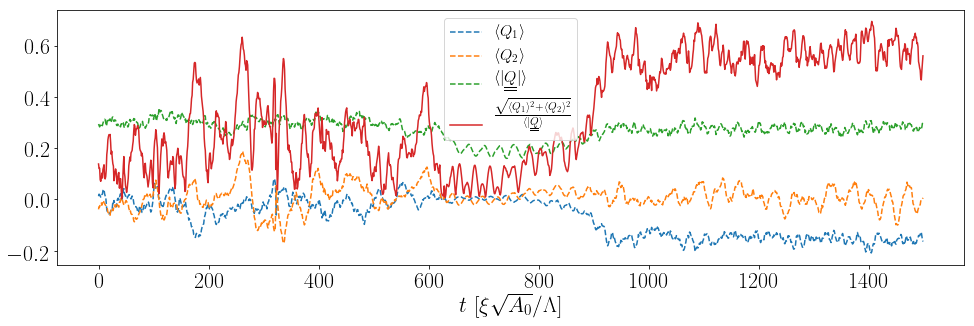

In [290]:
avg_Q1_t_cor = np.array(avg_Q1_t_cor)
avg_Q2_t_cor = np.array(avg_Q2_t_cor)
avg_norm_q_t_cor = np.array(avg_norm_q_t_cor)
#====================================================================
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.size": 22
})
fig, ax = plt.subplots(1, 1, figsize=(14,5))

QQ = np.sqrt(avg_Q1_t_cor**2 + avg_Q2_t_cor**2)/avg_norm_q_t_cor

t = range(t_i-1000, t_f-1000, 1)

ax.plot(t, avg_Q1_t_cor,'--', label="$\\langle Q_1\\rangle$")
ax.plot(t, avg_Q2_t_cor,'--', label="$\\langle Q_2\\rangle$")
ax.plot(t, avg_norm_q_t_cor,'--', label="$\\langle |\\underline{\\underline{Q}}|\\rangle$")
num = "\\sqrt{\\langle Q_1 \\rangle^2 + \\langle Q_2\\rangle^2}"
den = "\\langle |\\underline{\\underline{Q}}\\rangle"
ax.plot(t, QQ, label="$\\frac{"+num+"}{"+den+"}$")
ax.set_xlabel("$t \\,\\,[\\xi \\sqrt{A_0}/\\Lambda]$")
#ax.set_ylabel("$Q$")

plt.legend(fontsize=16)
plt.tight_layout()
plt.savefig("/home/aamiri/Desktop/r1_slant_Q1Q2_cor_axis.pdf")

### For selected frames, saving for all vertices: aph coors, dv, and 

In [4]:
# Import the essential python packages
import numpy as np
import pandas as pd
import os
import pwd
import sys
import importlib
import sys
sys.path.append('/data/biophys/aamiri/y2021/projects/organoids/rotationDraft/CurvedTM')
sys.path.append('/data/biophys/aamiri/y2021/projects/organoids/rotationDraft/CurvedTM/curvedtm')
sys.path.append('/data/biophys/aamiri/y2021/projects/organoids/rotationDraft/CurvedTM/curvedtm/trimesh')
# Import the essential python packages
sys.path.append('/data/biophys/aamiri/y2021/projects/organoids/rotationDraft/organoidanalyzer/angularVelocity/')
from CommonOperations import *

# To load and process meshes
import trimesh
import trimesh_extensions as mytri

# Curved Tissue Miner Packages
import geometry as MMGeom
import tools as MMTool
import curvature as MMCurv
import geometry_creation as geometry_methods
import curvedtm2vtk as CurvedTM2VTK
from pathlib import Path
#----------------------------------------------------------------

def bin_tta_profile(tta_vals, q_vals):
    bins = np.arange(0.2,np.pi-0.2,0.15)
    tta_binned = [np.nan]*len(bins)
    qs_binned = [np.nan]*len(bins)
    n_counts = [0]*len(bins)
    
    inds = np.digitize(tta_vals, bins)
    for i in range(len(bins)):
        bin_idx = inds==i
        n_counts[i] = sum(bin_idx)
        if n_counts[i]>0:
            tta_binned[i] = np.mean(tta_vals[bin_idx])
            qs_binned[i] = np.mean(q_vals[bin_idx])
    return np.array(tta_binned), np.array(qs_binned), n_counts

[0.08134496 0.00044111 0.16556704]


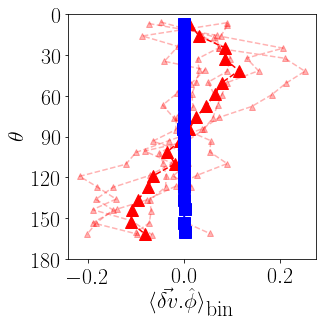

In [356]:
#====================================================================
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.size": 22
})
fig, ax = plt.subplots(1, 1, figsize=(5,5))
#---------------------------------

base_folder = "/data/biophys/aamiri/y2021/projects/organoids/rotationDraft/alpha_gamma_2/Nc200/r0/output_alpha_0.14_gamma_0.003_lambda0/"

data_folder_elong = base_folder + "elongations/"
data_folder_rotations = base_folder + "rotation_output/"

data_file_omega = data_folder_rotations + "Omega.txt"
omegas = np.loadtxt(data_file_omega)

t_disordered = np.array([1000, 1100, 1200, 1300, 1400])#['t=1000', 't=1100', 't=1200', 't=1300', 't=1400']
t_rotational = np.array([1900, 2000, 2100, 2200, 2300, 2400])#['t=1900', 't=2000', 't=2100', 't=2200', 't=2300', 't=2400']

avg_omegas = np.mean(omegas[1100:1400], axis=0)
print(avg_omegas)
align_with_avg_omega = False

num_bins = 30
bins = np.linspace(0,np.pi, num_bins)
t_i, t_f = 1000, 2500-1

# Disordered phase
ttas_to_avg = []
dvs_to_avg = []
for it in t_disordered:
    vertex_points = np.loadtxt(base_folder+"vertices_"+str(it)+".txt")
    vertex_points_t2 = np.loadtxt(base_folder+"vertices_"+str(it+1)+".txt")
#     Gamma, M = get_ang_momentum_inertia_tensor(vertex_points[:,0], vertex_points[:,1], vertex_points[:,2], vertex_points_t2[:,0], vertex_points_t2[:,1], vertex_points_t2[:,2], dt)
#     Omega_it = np.dot(lin.inv(M), Gamma)
    
    cell_list=[]
    with open(base_folder+"cells_"+str(it)+".txt") as f:
        [cell_list.append([int(i) for i in line.split()]) for line in f]
    apic_points, tri, cell_cents = triangulate__apical_surface(vertex_points, cell_list)
    cell_cents = np.array(cell_cents)
    data_file_elong = data_folder_elong + "cells_q_eigen_vecs_" + str(it) + ".txt"
    elong_eigen_vecs = np.loadtxt(data_file_elong)
    data_file_elong_norm = data_folder_elong + "cells_q_eigen_vals_" + str(it) + ".txt"
    elong_eigen_vals = np.loadtxt(data_file_elong_norm)
    #print(len(elong_eigen_vals))
    Nc = len(elong_eigen_vecs)
    Nv = len(vertex_points[:,0])
    if align_with_avg_omega:
        omg = avg_omegas
    else:
        omg = omegas[it-t_i]
        
    norm_omega = lin.norm(omg)
    ang = np.arccos(omg[2]/norm_omega)
    rot_axis = np.cross(omg, np.array([0,0,1]))

    vel = vertex_points_t2[:,0:3]-vertex_points[:,0:3]
    delta_v = vel-np.cross(omg,vertex_points[:,0:3])
    norm_delta_v = lin.norm(delta_v, axis=1)
    #omg = np.mean(omegas, axis=0)
    rot_delta_v = MT.rotation(delta_v, np.repeat(ang, Nv), np.repeat([rot_axis/np.linalg.norm(rot_axis)], Nv, axis=0))
    rot_vertex_points = MMTool.rotation(vertex_points[:,0:3], np.repeat(ang, Nv), np.repeat([rot_axis/np.linalg.norm(rot_axis)], Nv, axis=0))
    
    v_rr, v_tta, v_phi = cartesian_to_spherical(rot_vertex_points[:,0], rot_vertex_points[:,1], rot_vertex_points[:,2])
    
    phi_hat = np.zeros(np.shape(rot_vertex_points))
    tta_hat = np.zeros(np.shape(rot_vertex_points))
    phi_hat[:,0] = -np.sin(v_phi)
    phi_hat[:,1] = np.cos(v_phi)
    #phi_hat[:,2] = 0
    #...
    tta_hat[:,0] = np.cos(v_tta)* np.cos(v_phi)
    tta_hat[:,1] = np.cos(v_tta)* np.sin(v_phi)
    tta_hat[:,2] = -np.sin(v_tta)
    #...
    #q_phi_angles = []
    tta_vals, dv_dot_phi = [0]*Nv, [0]*Nv
    for cv in range(Nv):
        tta_vals[cv] = v_tta[cv]
        rq = rot_delta_v[cv]
        ph = phi_hat[cv]
        beta_val = np.dot(ph, rq)
        dv_dot_phi[cv] = beta_val

    tta_vals = np.array(tta_vals)
    dv_dot_phi = np.array(dv_dot_phi)
    tta_binned, dv_binned, n_count = bin_tta_profile(tta_vals, dv_dot_phi)  
    
    ax.plot(dv_binned, tta_binned*180/np.pi, 'r--^', alpha=0.3)
    ttas_to_avg.append(tta_binned)
    dvs_to_avg.append(dv_binned)
    
ttas_to_avg = np.array(ttas_to_avg)
dvs_to_avg = np.array(dvs_to_avg)
ax.plot(np.mean(dvs_to_avg, axis=0), np.mean(ttas_to_avg, axis=0)*180/np.pi,'r--^', markersize=12 )


#====
ttas_to_avg = []
dvs_to_avg = []
for it in t_rotational:
    vertex_points = np.loadtxt(base_folder+"vertices_"+str(it)+".txt")
    vertex_points_t2 = np.loadtxt(base_folder+"vertices_"+str(it+1)+".txt")
#     Gamma, M = get_ang_momentum_inertia_tensor(vertex_points[:,0], vertex_points[:,1], vertex_points[:,2], vertex_points_t2[:,0], vertex_points_t2[:,1], vertex_points_t2[:,2], dt)
#     Omega_it = np.dot(lin.inv(M), Gamma)
    
    cell_list=[]
    with open(base_folder+"cells_"+str(it)+".txt") as f:
        [cell_list.append([int(i) for i in line.split()]) for line in f]
    apic_points, tri, cell_cents = triangulate__apical_surface(vertex_points, cell_list)
    cell_cents = np.array(cell_cents)
    data_file_elong = data_folder_elong + "cells_q_eigen_vecs_" + str(it) + ".txt"
    elong_eigen_vecs = np.loadtxt(data_file_elong)
    data_file_elong_norm = data_folder_elong + "cells_q_eigen_vals_" + str(it) + ".txt"
    elong_eigen_vals = np.loadtxt(data_file_elong_norm)
    #print(len(elong_eigen_vals))
    Nc = len(elong_eigen_vecs)
    Nv = len(vertex_points[:,0])
    if align_with_avg_omega:
        omg = avg_omegas
    else:
        omg = omegas[it-t_i]
        
    norm_omega = lin.norm(omg)
    ang = np.arccos(omg[2]/norm_omega)
    rot_axis = np.cross(omg, np.array([0,0,1]))

    vel = vertex_points_t2[:,0:3]-vertex_points[:,0:3]
    delta_v = vel-np.cross(omg,vertex_points[:,0:3])
    norm_delta_v = lin.norm(delta_v, axis=1)
    #omg = np.mean(omegas, axis=0)
    rot_delta_v = MT.rotation(delta_v, np.repeat(ang, Nv), np.repeat([rot_axis/np.linalg.norm(rot_axis)], Nv, axis=0))
    rot_vertex_points = MMTool.rotation(vertex_points[:,0:3], np.repeat(ang, Nv), np.repeat([rot_axis/np.linalg.norm(rot_axis)], Nv, axis=0))
    
    v_rr, v_tta, v_phi = cartesian_to_spherical(rot_vertex_points[:,0], rot_vertex_points[:,1], rot_vertex_points[:,2])
    
    phi_hat = np.zeros(np.shape(rot_vertex_points))
    tta_hat = np.zeros(np.shape(rot_vertex_points))
    phi_hat[:,0] = -np.sin(v_phi)
    phi_hat[:,1] = np.cos(v_phi)
    #phi_hat[:,2] = 0
    #...
    tta_hat[:,0] = np.cos(v_tta)* np.cos(v_phi)
    tta_hat[:,1] = np.cos(v_tta)* np.sin(v_phi)
    tta_hat[:,2] = -np.sin(v_tta)
    #...
    #q_phi_angles = []
    tta_vals, dv_dot_phi = [0]*Nv, [0]*Nv
    for cv in range(Nv):
        tta_vals[cv] = v_tta[cv]
        rq = rot_delta_v[cv]
        ph = phi_hat[cv]
        beta_val = np.dot(ph, rq)
        dv_dot_phi[cv] = beta_val

    tta_vals = np.array(tta_vals)
    dv_dot_phi = np.array(dv_dot_phi)
    tta_binned, dv_binned, n_count = bin_tta_profile(tta_vals, dv_dot_phi)  
    
    ax.plot(dv_binned, tta_binned*180/np.pi, 'b--s', alpha=0.3)
    ttas_to_avg.append(tta_binned)
    dvs_to_avg.append(dv_binned)
    
ttas_to_avg = np.array(ttas_to_avg)
dvs_to_avg = np.array(dvs_to_avg)
ax.plot(np.mean(dvs_to_avg, axis=0), np.mean(ttas_to_avg, axis=0)*180/np.pi,'b--s', markersize=12 )

ax.set_xlabel("$\\langle \\vec{\\delta v}.\\hat{\\phi} \\rangle_\\textrm{bin}$")
ax.set_ylabel("$\\theta$")
ax.set_ylim([0, 180])
ax.set_yticks(np.arange(0, 190, 30))
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig("/home/aamiri/Desktop/tta_vs_dv.pdf")

### Edge length distributions

In [379]:
bf = "/data/biophys/aamiri/y2021/projects/organoids/rotationDraft/alpha_gamma_2/Nc200/"
data_folder0 = bf + "r0/output_alpha_0.14_gamma_0.003_lambda0/"
data_folder1 = bf + "r1/output_alpha_0.14_gamma_0.003_lambda0/"
data_folder2 = bf + "r0/output_alpha_0.08_gamma_0.003_lambda0/"
data_folder3 = bf + "r0/output_alpha_0.08_gamma_0.0_lambda0/"

In [380]:
def find_edge_list(cells_vert_ids):
    all_edges = []
    for c in cells_vert_ids:
        Nv = len(c)
        cell_edges = [[c[i], c[(i+1)%Nv]] for i in range(Nv)]
        for e in cell_edges:
            all_edges.append([min(e), max(e)])
    all_edges = np.array(all_edges)
    return np.unique(all_edges,axis=0)

def get_bond_length(data_folder, fr):
    cell_list=[]
    with open(data_folder+"cells_"+str(fr)+".txt") as f:
        [cell_list.append([int(i) for i in line.split()]) for line in f]
    all_unique_edges = find_edge_list(cell_list)

    vertex_points = np.loadtxt(data_folder+"vertices_"+str(fr)+".txt")
    vertex_points = vertex_points[:,0:3]
    bond_length = []
    for b in all_unique_edges:
        e = vertex_points[b]
        bond_length.append(np.linalg.norm(e[0]-e[1]))
    return np.array(bond_length)

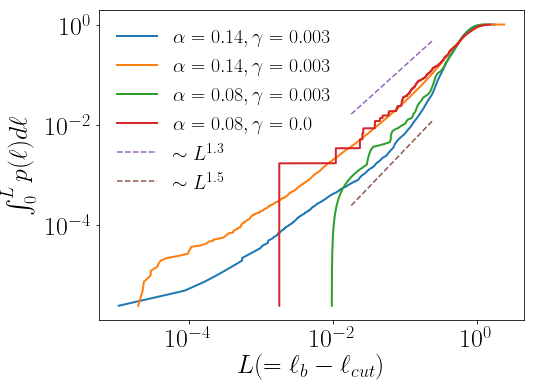

In [404]:
import numpy as np
import pandas as pd

from pathlib import Path
import os.path

import matplotlib.pyplot as plt

font = {'family' : 'tahoma',
       'weight' : 'normal',
       'size' : 26}
plt.rc('font', **font)

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif"
})
#===============================================
# bl0 = np.array([])
# bl1 = np.array([])
# bl2 = np.array([])
# bl3 = np.array([])

# for it in np.arange(1800, 2500):
#     bond_length0 = get_bond_length(data_folder0, it)
#     bond_length1 = get_bond_length(data_folder1, it)
#     bond_length2 = get_bond_length(data_folder2, it)
#     bond_length3 = get_bond_length(data_folder3, it)
#     bl0 = np.concatenate((bl0,bond_length0))
#     bl1 = np.concatenate((bl1,bond_length1))
#     bl2 = np.concatenate((bl2,bond_length2))
#     bl3 = np.concatenate((bl3,bond_length3))

# #print(np.shape(bl0))
# #================================================
plt.close("all")
fig, ax = plt.subplots(figsize=(8,6), ncols=1, nrows=1)

l_cut = 0.04

dN = 1/len(bl0)
#x = np.arange(dN, 1+dN, dN)
x = np.linspace(dN, 1+dN, len(bl0))
ax.plot(np.sort(bl0-l_cut), x, linewidth=2, label="$\\alpha=0.14,\\gamma = 0.003$")

dN = 1/len(bl1)
x = np.linspace(dN, 1+dN, len(bl1))
ax.plot(np.sort(bl1-l_cut), x, linewidth=2, label="$\\alpha=0.14,\\gamma = 0.003$")
#ax.hist(bond_length2, density=True, histtype='step', linewidth=2, label='$\\alpha=0.093$')
#ax.hist(bond_length3, density=True, histtype='step', linewidth=2, label='$\\alpha=0.103$')
dN = 1/len(bl2)
x = np.linspace(dN, 1+dN, len(bl2))
ax.plot(np.sort(bl2-l_cut), x, linewidth=2, label="$\\alpha=0.08,\\gamma = 0.003$")

dN = 1/len(bl3)
x = np.linspace(dN, 1+dN, len(bl3))
ax.plot(np.sort(bl3-l_cut), x, linewidth=2, label="$\\alpha=0.08,\\gamma = 0.0$")

xvs = np.linspace(0.018, 0.24, 100)
ax.plot(xvs, 3.*xvs**(1.3), '--', label="$\\sim L^{1.3}$")
ax.plot(xvs, 0.1*xvs**(1.5), '--', label="$\\sim L^{1.5}$")
ax.set_xlabel("$L (=\\ell_b - \\ell_{cut})$")
ax.set_ylabel("$\\int_0^{L}p(\\ell)d\\ell$")
ax.set_xscale('log')
ax.set_yscale('log')
plt.legend(fontsize=20, frameon=False)
plt.tight_layout()
plt.savefig("/home/aamiri/Desktop/P_l_800_1500.pdf")

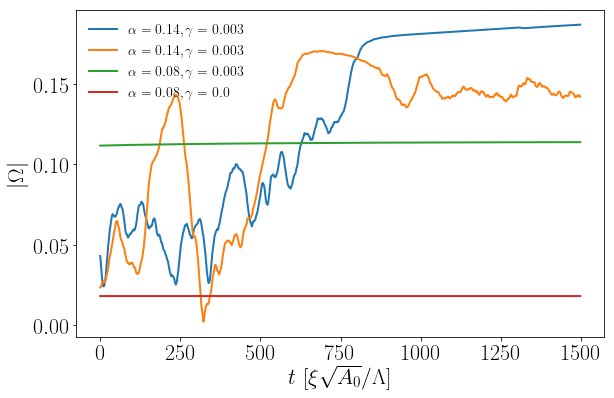

In [405]:
omg0_vec = np.loadtxt(data_folder0 + "rotation_output/Omega.txt")
omg0 = np.linalg.norm(omg0_vec, axis=1)
omg1_vec = np.loadtxt(data_folder1 + "rotation_output/Omega.txt")
omg1 = np.linalg.norm(omg1_vec, axis=1)
omg2_vec = np.loadtxt(data_folder2 + "rotation_output/Omega.txt")
omg2 = np.linalg.norm(omg2_vec, axis=1)
omg3_vec = np.loadtxt(data_folder3 + "rotation_output/Omega.txt")
omg3 = np.linalg.norm(omg3_vec, axis=1)

#=================================================
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.size": 22
})
fig, ax = plt.subplots(1, 1, figsize=(9,6))
#------------------------------------------

ax.plot(omg0, linewidth=2, label="$\\alpha=0.14,\\gamma = 0.003$")
ax.plot(omg1, linewidth=2, label="$\\alpha=0.14,\\gamma = 0.003$")
ax.plot(omg2, linewidth=2, label="$\\alpha=0.08,\\gamma = 0.003$")
ax.plot(omg3, linewidth=2, label="$\\alpha=0.08,\\gamma = 0.0$")

ax.set_xlabel("$t \\,\\,[\\xi \\sqrt{A_0}/\\Lambda]$")
ax.set_ylabel("$|\\Omega|$")
#plt.title("$\\alpha=0.14$")
plt.legend(fontsize=14, frameon=False)#, loc="upper left")
plt.tight_layout()
plt.savefig("/home/aamiri/Desktop/norm_Omega_t.pdf")

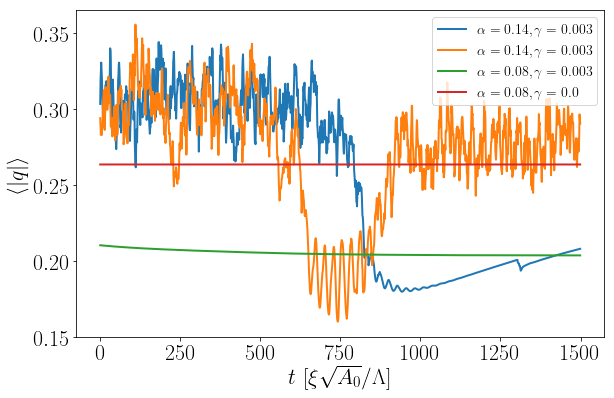

In [406]:
q0_v, q1_v, q2_v, q3_v = [], [], [], []
for fr in np.arange(1000, 2500, 1):
    q0 = np.loadtxt(data_folder0+"elongations/cells_q_eigen_vals_"+str(fr)+".txt")
    q0_v.append(np.mean(q0))
    q1 = np.loadtxt(data_folder1+"elongations/cells_q_eigen_vals_"+str(fr)+".txt")
    q1_v.append(np.mean(q1))
    q2 = np.loadtxt(data_folder2+"elongations/cells_q_eigen_vals_"+str(fr)+".txt")
    q2_v.append(np.mean(q2))
    q3 = np.loadtxt(data_folder3+"elongations/cells_q_eigen_vals_"+str(fr)+".txt")
    q3_v.append(np.mean(q3))
    
#=================================================
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.size": 22
})
fig, ax = plt.subplots(1, 1, figsize=(9,6))
#------------------------------------------

ax.plot(q0_v, linewidth=2, label="$\\alpha=0.14,\\gamma = 0.003$")
ax.plot(q1_v, linewidth=2, label="$\\alpha=0.14,\\gamma = 0.003$")
ax.plot(q2_v, linewidth=2, label="$\\alpha=0.08,\\gamma = 0.003$")
ax.plot(q3_v, linewidth=2, label="$\\alpha=0.08,\\gamma = 0.0$")

ax.set_xlabel("$t \\,\\,[\\xi \\sqrt{A_0}/\\Lambda]$")
ax.set_ylabel("$\\langle|q|\\rangle$")
#plt.title("$\\alpha=0.14$")
plt.legend(fontsize=14)#, loc="upper left")
plt.tight_layout()
plt.savefig("/home/aamiri/Desktop/avg_norm_q_t.pdf")

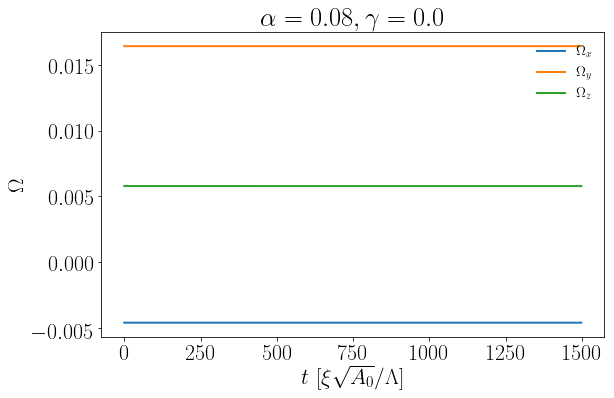

In [433]:
omg0_vec = np.loadtxt(data_folder0 + "rotation_output/Omega.txt")
omg0 = np.linalg.norm(omg0_vec, axis=1)
omg1_vec = np.loadtxt(data_folder1 + "rotation_output/Omega.txt")
omg1 = np.linalg.norm(omg1_vec, axis=1)
omg2_vec = np.loadtxt(data_folder2 + "rotation_output/Omega.txt")
omg2 = np.linalg.norm(omg2_vec, axis=1)
omg3_vec = np.loadtxt(data_folder3 + "rotation_output/Omega.txt")
omg3 = np.linalg.norm(omg3_vec, axis=1)

#=================================================
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.size": 22
})
fig, ax = plt.subplots(1, 1, figsize=(9,6))
#------------------------------------------

ax.plot(omg3_vec[:,0], linewidth=2, label="$\\Omega_x$")
ax.plot(omg3_vec[:,1], linewidth=2, label="$\\Omega_y$")
ax.plot(omg3_vec[:,2], linewidth=2, label="$\\Omega_z$")
plt.title("$\\alpha=0.08,\\gamma = 0.0$")

# ax.plot(omg1, linewidth=2, label="$\\alpha=0.14,\\gamma = 0.003$")
# ax.plot(omg2, linewidth=2, label="$\\alpha=0.08,\\gamma = 0.003$")
# ax.plot(omg3, linewidth=2, label="$\\alpha=0.08,\\gamma = 0.0$")

ax.set_xlabel("$t \\,\\,[\\xi \\sqrt{A_0}/\\Lambda]$")
ax.set_ylabel("$\\Omega$")

plt.legend(fontsize=14, frameon=False)#, loc="upper left")
plt.tight_layout()
plt.savefig("/home/aamiri/Desktop/comp_Omega_t_alpha_0p08_0_r0.pdf")

In [436]:
bf = "/data/biophys/aamiri/y2021/projects/organoids/rotationDraft/alpha_gamma_2/Nc200/"

bl = np.array([])
for r in ["r0", "r1", "r2", "r3", "r4", "r5", "r6", "r7", "r8", "r9"]:
    data_folder = bf +r+"/output_alpha_0.08_gamma_0.0_lambda0/"
    for it in np.arange(1800, 2500):
        bond_length = get_bond_length(data_folder, it)
        bl = np.concatenate((bl,bond_length))
        
np.savetxt("/home/aamiri/Desktop/bond_length/bond_lengths_alpha_0p08_gamma_0.txt", bl, fmt="%.14f")

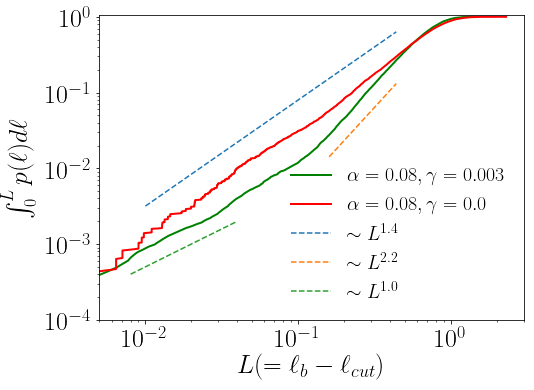

In [473]:
# bl_alpha_0p08_gamma_0 = np.loadtxt("/home/aamiri/Desktop/bond_length/bond_lengths_alpha_0p08_gamma_0.txt")
# bl_alpha_0p08_gamma_0p003 = np.loadtxt("/home/aamiri/Desktop/bond_length/bond_lengths_alpha_0p08_gamma_0p003.txt")

#===========================
import numpy as np
import pandas as pd

from pathlib import Path
import os.path

import matplotlib.pyplot as plt

font = {'family' : 'tahoma',
       'weight' : 'normal',
       'size' : 26}
plt.rc('font', **font)

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif"
})
#=============================
plt.close("all")
fig, ax = plt.subplots(figsize=(8,6), ncols=1, nrows=1)

l_cut = 0.04

dN = 1/len(bl_alpha_0p08_gamma_0p003)
#x = np.arange(dN, 1+dN, dN)
x = np.linspace(dN, 1+dN, len(bl_alpha_0p08_gamma_0p003))
ax.plot(np.sort(bl_alpha_0p08_gamma_0p003-l_cut), x, 'g-', linewidth=2, label="$\\alpha=0.08,\\gamma = 0.003$")

dN = 1/len(bl_alpha_0p08_gamma_0)
#x = np.arange(dN, 1+dN, dN)
x = np.linspace(dN, 1+dN, len(bl_alpha_0p08_gamma_0))
ax.plot(np.sort(bl_alpha_0p08_gamma_0-l_cut), x, 'r-', linewidth=2, label="$\\alpha=0.08,\\gamma = 0.0$")

xvs = np.linspace(0.01, 0.44, 100)
ax.plot(xvs, 2.*xvs**(1.4), '--', label="$\\sim L^{1.4}$")

xvs = np.linspace(0.16, 0.44, 100)
ax.plot(xvs, 0.8*xvs**(2.2), '--', label="$\\sim L^{2.2}$")

xvs = np.linspace(0.008, 0.04, 100)
ax.plot(xvs, 0.05*xvs**(1.), '--', label="$\\sim L^{1.0}$")

ax.set_xlim([0.005, 3])
ax.set_ylim([0.0001, 1.06])

ax.set_xlabel("$L (=\\ell_b - \\ell_{cut})$")
ax.set_ylabel("$\\int_0^{L}p(\\ell)d\\ell$")
ax.set_xscale('log')
ax.set_yscale('log')
plt.legend(fontsize=20, frameon=False)
plt.tight_layout()
plt.savefig("/home/aamiri/Desktop/bond_length/P_l_800_1500_alpha_0p08.pdf")

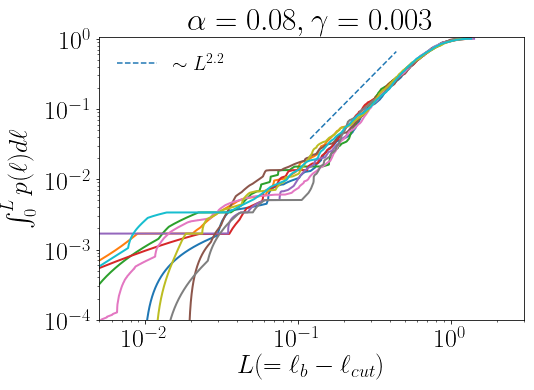

In [475]:
# bl_alpha_0p08_gamma_0 = np.loadtxt("/home/aamiri/Desktop/bond_length/bond_lengths_alpha_0p08_gamma_0.txt")
# bl_alpha_0p08_gamma_0p003 = np.loadtxt("/home/aamiri/Desktop/bond_length/bond_lengths_alpha_0p08_gamma_0p003.txt")

#===========================
import numpy as np
import pandas as pd

from pathlib import Path
import os.path

import matplotlib.pyplot as plt

font = {'family' : 'tahoma',
       'weight' : 'normal',
       'size' : 26}
plt.rc('font', **font)

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif"
})
#=============================
plt.close("all")
fig, ax = plt.subplots(figsize=(8,6), ncols=1, nrows=1)

l_cut = 0.04

ch_size = len(bl_alpha_0p08_gamma_0p003)/10 
for pp in range(10):
    data_ch = bl_alpha_0p08_gamma_0p003[int(ch_size*pp):int(ch_size*(pp+1))]
    dN = 1/len(data_ch)
    x = np.linspace(dN, 1+dN, len(data_ch))
    ax.plot(np.sort(data_ch-l_cut), x, linewidth=2)#, label="$\\textrm{r}="+str(pp)+"$")

# dN = 1/len(bl_alpha_0p08_gamma_0p003)
# #x = np.arange(dN, 1+dN, dN)
# x = np.linspace(dN, 1+dN, len(bl_alpha_0p08_gamma_0p003))
# ax.plot(np.sort(bl_alpha_0p08_gamma_0p003-l_cut), x, linewidth=2, label="$\\alpha=0.08,\\gamma = 0.003$")

xvs = np.linspace(0.12, 0.44, 100)
ax.plot(xvs, 4.*xvs**(2.2), '--', label="$\\sim L^{2.2}$")
# ax.plot(xvs, 0.6*xvs**(2.1), '--', label="$\\sim L^{2.1}$")

# xvs = np.linspace(0.02, 0.06, 100)
# ax.plot(xvs, 0.19*xvs**(1.3), '--', label="$\\sim L^{1.3}$")

ax.set_xlim([0.005, 3])
ax.set_ylim([0.0001, 1.06])

ax.set_xlabel("$L (=\\ell_b - \\ell_{cut})$")
ax.set_ylabel("$\\int_0^{L}p(\\ell)d\\ell$")
ax.set_xscale('log')
ax.set_yscale('log')
plt.title("$\\alpha=0.08,\\gamma = 0.003$")
plt.legend(fontsize=20, frameon=False)
plt.tight_layout()
plt.savefig("/home/aamiri/Desktop/bond_length/P_l_alpha_0p08_gamma0p003_all_realizations.pdf")

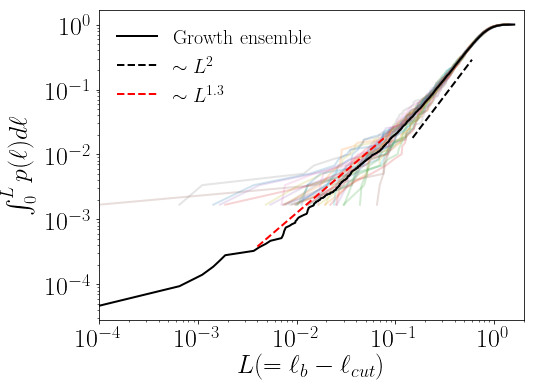

In [686]:
bf = "/data/biophys/aamiri/y2021/projects/organoids/rotationDraft/alpha_gamma_2/growth/"

N_realisations = 36


# for ir in range(N_realisations):
#     r = "r"+str(ir)
#     data_folder = bf +r+"/output_alpha_0.08_gamma_0.003_lambda0_div/"
#     it = 179
#     bond_length = get_bond_length(data_folder, it)
#     np.savetxt(data_folder + "bond_lengths.txt", bond_length, fmt="%.14f")

#========================
import numpy as np
import pandas as pd

from pathlib import Path
import os.path

import matplotlib.pyplot as plt

font = {'family' : 'tahoma',
       'weight' : 'normal',
       'size' : 26}
plt.rc('font', **font)

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif"
})
#=============================
plt.close("all")
fig, ax = plt.subplots(figsize=(8,6), ncols=1, nrows=1)

l_cut = 0.04

bl = np.array([])
for ir in range(N_realisations):
    r = "r"+str(ir)
    data_folder = bf +r+"/output_alpha_0.08_gamma_0.003_lambda0_div/"
    b_lenghs = np.loadtxt(data_folder+"bond_lengths.txt")
    dN = 1/len(b_lenghs)
    x = np.linspace(dN, 1+dN, len(b_lenghs))
    ax.plot(np.sort(b_lenghs-l_cut), x, '-', linewidth=2, alpha=0.2)#, label="$\\alpha=0.08,\\gamma = 0.003$")
    bl = np.concatenate((bl,b_lenghs))

bl_growth = bl
dN = 1/len(bl)
x = np.linspace(dN, 1+dN, len(bl))
ax.plot(np.sort(bl-l_cut), x, 'k-', linewidth=2, label="$\\textrm{Growth ensemble}$")

xvs = np.linspace(0.15, 0.6, 100)
ax.plot(xvs, 0.8*xvs**(2), 'k--', linewidth=2, label="$\\sim L^{2}$")

xvs = np.linspace(0.004, 0.08, 100)
ax.plot(xvs, 0.5*xvs**(1.3), 'r--', linewidth=2, label="$\\sim L^{1.3}$")

ax.set_xlim([0.0001, 2])
ax.set_xlabel("$L (=\\ell_b - \\ell_{cut})$")
ax.set_ylabel("$\\int_0^{L}p(\\ell)d\\ell$")
ax.set_xscale('log')
ax.set_yscale('log')
#plt.title("$\\alpha=0.08,\\gamma = 0.003$")
plt.legend(fontsize=20, frameon=False)
plt.tight_layout()
plt.savefig(bf+"/average_bond_lenght_dist.pdf")

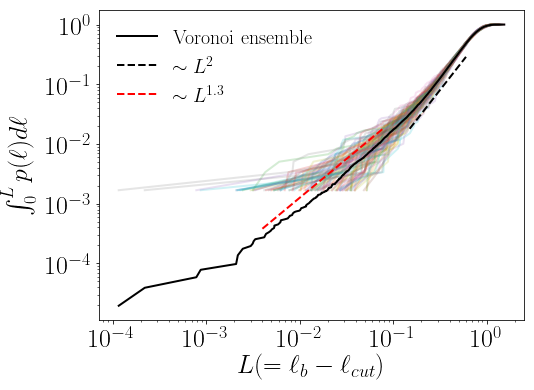

In [683]:
bf = "/data/biophys/aamiri/y2021/projects/organoids/rotationDraft/alpha_gamma_2/voronoi_ensemble"

N_sample = 86

for r in range(N_sample):
    data_folder = bf +"/output_alpha_0.08_gamma_0.003_lambda0/"
    bond_length = get_bond_length(data_folder, r)
    np.savetxt(data_folder + "bond_lengths_"+str(r)+".txt", bond_length, fmt="%.14f")

#========================
import numpy as np
import pandas as pd

from pathlib import Path
import os.path

import matplotlib.pyplot as plt

font = {'family' : 'tahoma',
       'weight' : 'normal',
       'size' : 26}
plt.rc('font', **font)

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif"
})
#=============================
plt.close("all")
fig, ax = plt.subplots(figsize=(8,6), ncols=1, nrows=1)

l_cut = 0.04

bl = np.array([])
for r in range(N_sample):
    data_folder = bf +"/output_alpha_0.08_gamma_0.003_lambda0/"
    bond_length = get_bond_length(data_folder, r)
    b_lenghs = np.loadtxt(data_folder+"bond_lengths_"+str(r)+".txt")
    dN = 1/len(b_lenghs)
    x = np.linspace(dN, 1+dN, len(b_lenghs))
    ax.plot(np.sort(b_lenghs-l_cut), x, '-', linewidth=2, alpha=0.2)#, label="$\\alpha=0.08,\\gamma = 0.003$")
    bl = np.concatenate((bl,b_lenghs))
    
bl_voronoi = bl    
dN = 1/len(bl)
x = np.linspace(dN, 1+dN, len(bl))
ax.plot(np.sort(bl-l_cut), x, 'k-', linewidth=2, label="$\\textrm{Voronoi ensemble}$")

xvs = np.linspace(0.15, 0.6, 100)
ax.plot(xvs, 0.8*xvs**(2), 'k--', linewidth=2, label="$\\sim L^{2}$")

xvs = np.linspace(0.004, 0.08, 100)
ax.plot(xvs, 0.5*xvs**(1.3), 'r--', linewidth=2, label="$\\sim L^{1.3}$")

ax.set_xlabel("$L (=\\ell_b - \\ell_{cut})$")
ax.set_ylabel("$\\int_0^{L}p(\\ell)d\\ell$")
ax.set_xscale('log')
ax.set_yscale('log')
#plt.title("$\\alpha=0.08,\\gamma = 0.003$")
plt.legend(fontsize=20, frameon=False)
plt.tight_layout()
plt.savefig(bf+"/average_bond_lenght_dist.pdf")

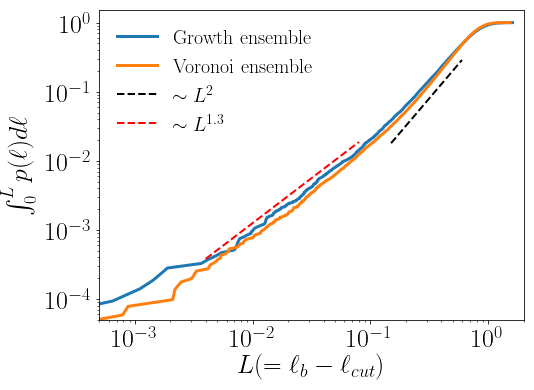

In [685]:
import numpy as np
import pandas as pd

from pathlib import Path
import os.path

import matplotlib.pyplot as plt

font = {'family' : 'tahoma',
       'weight' : 'normal',
       'size' : 26}
plt.rc('font', **font)

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif"
})

#=============================
plt.close("all")
fig, ax = plt.subplots(figsize=(8,6), ncols=1, nrows=1)

dN = 1/len(bl_growth)
x = np.linspace(dN, 1+dN, len(bl_growth))
ax.plot(np.sort(bl_growth-l_cut), x, '-', linewidth=3, label="$\\textrm{Growth ensemble}$")

dN = 1/len(bl_voronoi)
x = np.linspace(dN, 1+dN, len(bl_voronoi))
ax.plot(np.sort(bl_voronoi-l_cut), x, '-', linewidth=3, label="$\\textrm{Voronoi ensemble}$")

xvs = np.linspace(0.15, 0.6, 100)
ax.plot(xvs, 0.8*xvs**(2), 'k--', linewidth=2, label="$\\sim L^{2}$")

xvs = np.linspace(0.004, 0.08, 100)
ax.plot(xvs, 0.5*xvs**(1.3), 'r--', linewidth=2, label="$\\sim L^{1.3}$")

ax.set_xlim([0.0005, 2])
ax.set_ylim([0.00005, 1.5])
ax.set_xlabel("$L (=\\ell_b - \\ell_{cut})$")
ax.set_ylabel("$\\int_0^{L}p(\\ell)d\\ell$")
ax.set_xscale('log')
ax.set_yscale('log')
#plt.title("$\\alpha=0.08,\\gamma = 0.003$")
plt.legend(fontsize=20, frameon=False)
plt.tight_layout()
plt.savefig("/data/biophys/aamiri/y2021/projects/organoids/rotationDraft/alpha_gamma_2/average_bond_lenght_dist_ensembles.pdf")